# **ПРИЛОЖЕНИЕ К ИТОГОВОМУ ПРОЕКТУ ПО ПРОГРАММЕ "СПЕЦИАЛИСТ ПО DATA SCIENCE" (DS-15)**

# По теме: **Устойчивость моделей к шуму и выбросам**

*Целью проекта является* разработка, метрологическое обоснование и возможность практического применения робастного пайплайна при предобработке данных технических испытаний медицинских изделий для оценки неопределенности измерений в контролируемых лабораторных условиях.

Ключевая задача - повысить достоверность и точность измерений с помощью моделей машинного обучения для последующей оценки неопределенности, которые:
- Эффективно подавляют шумы и идентифицирует/корректирует выбросы, обусловленные внешними помехами или артефактами измерений;
- Сохраняют аномалии, потенциально указывающие на техническую неисправность или некорректную работу испытываемого изделия;
- Являются прозрачными, валидируемыми и соответствуют требованиям ГОСТ 34100.3-2017 (GUM), ГОСТ Р ИСО 5725-1 (Точность методов и результатов измерений) и, прежде всего, ГОСТ ISO/IEC 17025-2019 (в части требований к оценке неопределенности (7.6), выбору, верификации и валидации методов (7.2) и достоверности результатов (7.7)).


Для осуществления поставленной цели необходимо выполнить следующие задачи:
- Генерация синтетических данных технических испытаний медицинских изделий (ГЛАВА 1);
- Обзор ML-моделей (ГЛАВА 2);
- Эмперическое сравнение ML-моделей (ГЛАВА 3);
- Анализ влияния шума/выбросов на оценку неопредленности измерений ML-моделей в сравнении со стандартными подходами GUM (ГЛАВА 4);
- Выводы и рекомендации для лабораторий на основе полученных данных.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import shap
!pip install pywt xgboost
import pywt
import os
from scipy.signal import medfilt
!pip install xgboost

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


## **ГЛАВА 1. ГЕНЕРАЦИЯ СИНТЕТИЧЕСКИХ ДАННЫХ**

---

### Моделирование идеальных данных испытаний

Один цикл измерения (от вдоха до выдоха) давления в дыхательном контуре ИВЛ (200 точек)

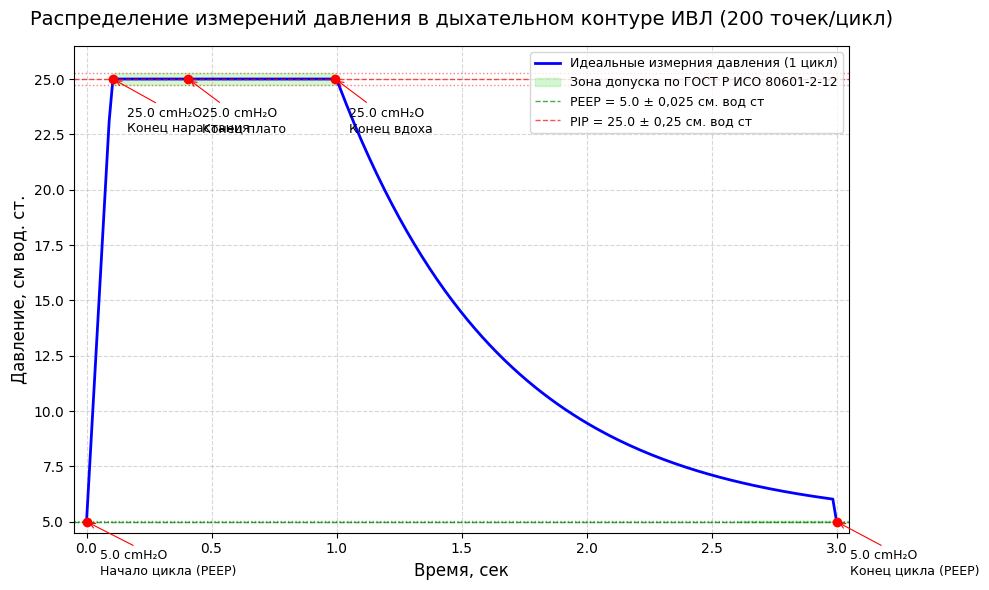

Развернутый просмотр одного цикла:
 - Количество точек: 200
 - Интервал между измерениями: 0.0151 с (15.1 мс)
 - Фазы:
   · Фаза нарастания (Rise): от 0 до 0.10 с
   · Фаза плато       : от 0.10 до 0.40 с
   · Фаза удержания   : от 0.40 до 1.00 с
   · Фаза экспирации  : от 1.00 до 3.00 с


In [ ]:
# ПАРАМЕТРЫ ИСПЫТАНИЯ (СОГЛАСНО ГОСТ Р ИСО 80601-2-12)
PEEP        = 5.0       # cmH₂O (±0.5%)
PINSP       = 25.0      # cmH₂O (±1.0%)
f_resp      = 20 / 60.0 # 20 циклов/мин → T_total = 3.0 с
I_E         = (1, 2)    # соотношение вдох:выдох = 1:2
rise_time   = 0.10      # 100 мс (линейное нарастание)
plateau_time= 0.30      # 300 мс (период плато)
tol_peep    = 0.005     # ±0.5% для PEEP
tol_pinsp   = 0.01      # ±1.0% для PIP

# ВЫЧИСЛЕНИЕ ВРЕМЕННЫХ ПАРАМЕТРОВ
T_total = 1.0 / f_resp                       # полный цикл = 3.0 с
T_insp  = T_total * I_E[0] / sum(I_E)        # время вдоха = 1.0 с
T_exp   = T_total - T_insp                   # время выдоха = 2.0 с

# ПРОВЕРКА, ЧТО ФАЗЫ НЕ ПЕРЕСЕКАЮТСЯ
assert rise_time + plateau_time <= T_insp,    "Rise + plateau дольше вдоха"
assert T_exp >= 3 * rise_time,                "Выдох слишком короткий для плавного спада"

# ГЕНЕРАЦИЯ ВРЕМЕННОГО МАССИВА
points_per_cycle = 200
t_cycle = np.linspace(0, T_total, points_per_cycle)

# ФУНКЦИЯ ДЛЯ ГЕНЕРАЦИИ ПРОФИЛЯ ДАВЛЕНИЯ
def gen_one_cycle(t_arr):
    pressure = np.full_like(t_arr, PEEP)  # Инициализируем PEEP

    # ГРАНИЦЫ ФАЗ ВНУТРИ ЦИКЛА
    t_r_end = rise_time
    t_p_end = rise_time + plateau_time

    # 1) Фаза линейного нарастания: 0 → t_r_end
    rise_mask = (t_arr < t_r_end)
    pressure[rise_mask] = PEEP + (PINSP - PEEP) * (t_arr[rise_mask] / rise_time)

    # 2) Фаза плато: t_r_end → t_p_end
    plateau_mask = (t_arr >= t_r_end) & (t_arr < t_p_end)
    pressure[plateau_mask] = PINSP

    # 3) Фаза удержания PIP: t_p_end → T_insp
    hold_mask = (t_arr >= t_p_end) & (t_arr < T_insp)
    pressure[hold_mask] = PINSP

    # 4) Фаза экспирации (экспоненциальный спад): T_insp → T_total
    exp_mask = (t_arr >= T_insp)
    tau = T_exp / 3.0
    t_rel = t_arr[exp_mask] - T_insp
    pressure[exp_mask] = PEEP + (PINSP - PEEP) * np.exp(-t_rel / tau)

    # ПОСЛЕДНЯЯ ТОЧКА = PEEP
    pressure[-1] = PEEP

    return pressure

# ГЕНЕРАЦИЯ ЦИКЛА
pressure_cycle = gen_one_cycle(t_cycle)

# ПОСТРОЕНИЕ ГРАФИКА
plt.figure(figsize=(10, 6))

# 1) ОСНОВНАЯ КРИВАЯ ДАВЛЕНИЯ
plt.plot(
    t_cycle,
    pressure_cycle,
    color='blue',
    linewidth=2,
    label='Идеальные измерния давления (1 цикл)'
)

# 2) ФОРМИРОВАНИЕ ЗОН ДОПУСКОВ
upper_limit = np.full_like(t_cycle, np.nan)
lower_limit = np.full_like(t_cycle, np.nan)

# Допуск для PIP (±1%) во время плато и удержания (c 0.10 до 1.00 с)
insp_tol_mask = (t_cycle >= rise_time) & (t_cycle < T_insp)
upper_limit[insp_tol_mask] = PINSP * (1 + tol_pinsp)
lower_limit[insp_tol_mask] = PINSP * (1 - tol_pinsp)

# Допуск для PEEP (±0.5%) в последние 20% выдоха
peep_end_start = T_insp + 0.8 * T_exp
peep_end_mask = (t_cycle >= peep_end_start) & (t_cycle <= T_total)
upper_limit[peep_end_mask] = PEEP * (1 + tol_peep)
lower_limit[peep_end_mask] = PEEP * (1 - tol_peep)

# ЗАЛИВКА ОБЛАСТИ МЕЖДУ ДОПУСКАМИ
plt.fill_between(
    t_cycle,
    lower_limit,
    upper_limit,
    where=~np.isnan(lower_limit),
    color='lightgreen',
    alpha=0.4,
    label='Зона допуска по ГОСТ Р ИСО 80601-2-12'
)

# 3) ОТМЕТКА КЛЮЧЕВЫХ ТОЧЕК
control_points = [
    (0.0,                     PEEP, 'Начало цикла (PEEP)'),
    (rise_time,               PINSP, 'Конец нарастания'),
    (rise_time + plateau_time, PINSP, 'Конец плато'),
    (T_insp,                  PINSP, 'Конец вдоха'),
    (T_total,                 PEEP,  'Конец цикла (PEEP)')
]

for t_pt, p_pt, label in control_points:
    idx = np.abs(t_cycle - t_pt).argmin()
    actual_t = t_cycle[idx]
    actual_p = pressure_cycle[idx]

    plt.plot(
        actual_t,
        actual_p,
        marker='o',
        color='red',
        markersize=6,
        zorder=5
    )
    plt.annotate(
        f"{actual_p:.1f} cmH₂O\n{label}",
        (actual_t, actual_p),
        xytext=(10, -20),
        textcoords='offset points',
        ha='left',
        va='top',
        fontsize=9,
        arrowprops=dict(
            arrowstyle='->',
            color='red',
            linewidth=0.8
        )
    )

# 4) ГОРИЗОНТАЛЬНЫЕ ЛИНИИ НОМИНАЛОВ И ДОПУСКОВ
# Номиналы PEEP и PIP
plt.axhline(
    PEEP,
    color='green',
    linestyle='--',
    linewidth=1,
    alpha=0.7,
    label=f'PEEP = {PEEP} ± 0,025 см. вод ст'
)

plt.axhline(
    PINSP,
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.7,
    label=f'PIP = {PINSP} ± 0,25 cм. вод ст'
)

#  Линии пределов допуска (для наглядности)
plt.axhline(
    PEEP * (1 + tol_peep),
    color='green',
    linestyle=':',
    linewidth=1,
    alpha=0.5
)

plt.axhline(
    PEEP * (1 - tol_peep),
    color='green',
    linestyle=':',
    linewidth=1,
    alpha=0.5
)

plt.axhline(
    PINSP * (1 + tol_pinsp),
    color='red',
    linestyle=':',
    linewidth=1,
    alpha=0.5
)

plt.axhline(
    PINSP * (1 - tol_pinsp),
    color='red',
    linestyle=':',
    linewidth=1,
    alpha=0.5
)

# 5) Оформление графика
plt.title(
    'Распределение измерений давления в дыхательном контуре ИВЛ (200 точек/цикл)',
    fontsize=14,
    pad=15
)
plt.xlabel('Время, сек', fontsize=12)
plt.ylabel('Давление, см вод. ст.', fontsize=12)
plt.xlim(-0.05, T_total + 0.05)
plt.ylim(4.5, 26.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()

# Сохранение рисунка
plt.savefig('one_cycle_detailed.png', dpi=300, bbox_inches='tight')

plt.show()

# ПАРАМЕТРЫ ЦИКЛА
n_points = len(t_cycle)
dt = T_total / (n_points - 1)

print("Развернутый просмотр одного цикла:")
print(f" - Количество точек: {n_points}")
print(f" - Интервал между измерениями: {dt:.4f} с ({dt*1000:.1f} мс)")
print(f" - Фазы:")
print(f"   · Фаза нарастания (Rise): от 0 до {rise_time:.2f} с")
print(f"   · Фаза плато       : от {rise_time:.2f} до {rise_time + plateau_time:.2f} с")
print(f"   · Фаза удержания   : от {rise_time + plateau_time:.2f} до {T_insp:.2f} с")
print(f"   · Фаза экспирации  : от {T_insp:.2f} до {T_total:.2f} с")



Масштабирование. 5 циклов измерений давления в дыхательном контуре ИВЛ (1000 точек)

Чтобы использовать данные в дальнейших экспериментах (при обучении моделей), масштабируем его на 1000 временных точек. В реальной лабораторной практике может потребоваться измерение нескольких циклов подряд. В нашем случае циклов будет 5 по 200 точек измерений на цикл.

In [ ]:
# Параметры испытания и допуска
PEEP = 5.0                # cм. вод ст. (±0.5%)
PINSP = 25.0              # cм. вод. ст. (±1.0%)
f_resp = 20 / 60.0        # 20 циклов/мин → T_total = 3.0 с
I_E = (1, 2)              # соотношение вдох:выдох = 1:2
rise_time = 0.10          # 100 мс (период линейного нарастания)
plateau_time = 0.30       # 300 мс (период плато)
tol_peep = 0.005          # ±0.5% для PEEP
tol_pinsp = 0.01          # ±1.0% для PIP

# Вычисляем временные параметры
T_total = 1.0 / f_resp                           # = 3.0 сек
T_insp = T_total * I_E[0] / sum(I_E)             # = 1.0 сек
T_exp = T_total - T_insp                         # = 2.0 сек

# Проверка допусков (костыль, чтобы не поломалось при изменении параметров)
assert rise_time + plateau_time <= T_insp, "Нарушение границ фаз вдоха"
assert T_exp >= 3 * rise_time, "Недостаточное время на выдох"

# Генерация временной сетки для 1 цикла
points_per_cycle = 200
t_cycle = np.linspace(0, T_total, points_per_cycle)

# Генерация профиля давления для одного цикла
def gen_one_cycle(t_arr):
    pressure = np.full_like(t_arr, PEEP)
    # Временные границы фаз
    t_r_end = rise_time
    t_p_end = rise_time + plateau_time

    # 1. Фаза нарастания
    rise_mask = t_arr < t_r_end
    pressure[rise_mask] = PEEP + (PINSP - PEEP) * (t_arr[rise_mask] / rise_time)

    # 2. Фаза плато
    plateau_mask = (t_arr >= t_r_end) & (t_arr < t_p_end)
    pressure[plateau_mask] = PINSP

    # 3. Фаза удержания пика (далее до конца вдоха)
    hold_mask = (t_arr >= t_p_end) & (t_arr < T_insp)
    pressure[hold_mask] = PINSP

    # 4. Фаза экспирации (экспоненциальный спад)
    exp_mask = t_arr >= T_insp
    tau = T_exp / 3.0
    t_rel = t_arr[exp_mask] - T_insp
    pressure[exp_mask] = PEEP + (PINSP - PEEP) * np.exp(-t_rel / tau)

    # Гарантируем точное значение PEEP в конце цикла
    pressure[-1] = PEEP
    return pressure

# Генерация 5 циклов подряд
num_cycles = 5
t_all = np.concatenate([t_cycle + i * T_total for i in range(num_cycles)])
pressure_all = np.concatenate([gen_one_cycle(t_cycle) for _ in range(num_cycles)])

data_to_save = np.column_stack((t_all, pressure_all))

np.savetxt(
    'pressure_5_cycles.csv',
    data_to_save,
    delimiter=',',
    header='Time(s),Pressure(cм. вод. ст.)',
    comments='',
    fmt='%.4f'
)

print(f"Сохранено {data_to_save.shape[0]} строк в pressure_5_cycles.csv")
print("Первые 5 строк файла:")
print(data_to_save[:5])

Сохранено 1000 строк в pressure_5_cycles.csv
Первые 5 строк файла:
[[0.00000000e+00 5.00000000e+00]
 [1.50753769e-02 8.01507538e+00]
 [3.01507538e-02 1.10301508e+01]
 [4.52261307e-02 1.40452261e+01]
 [6.03015075e-02 1.70603015e+01]]


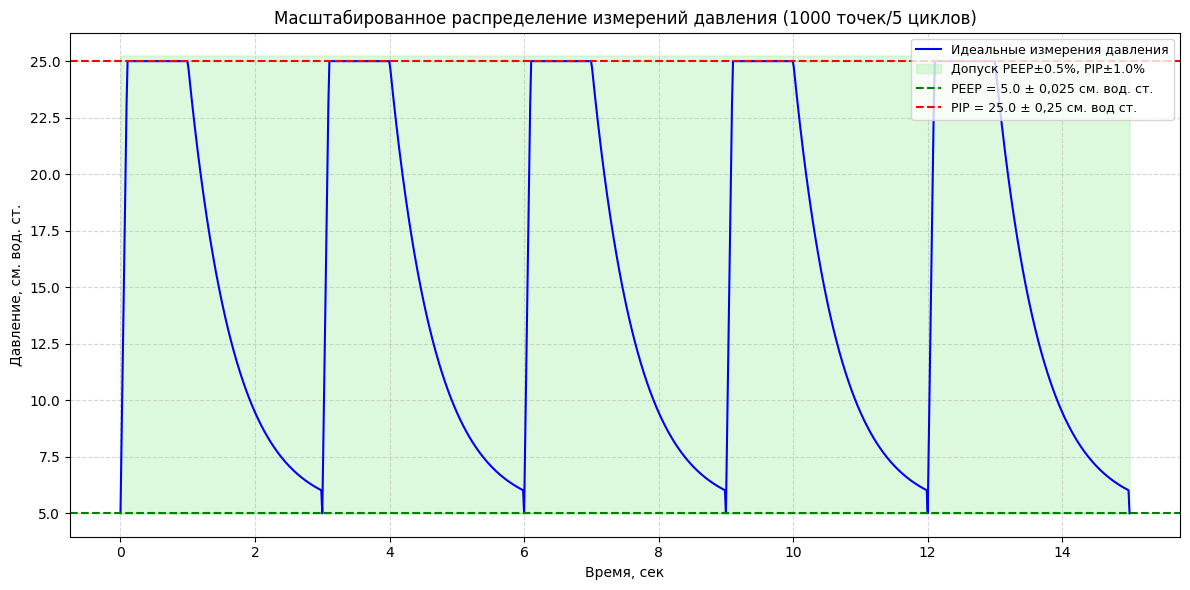

In [ ]:
# Настраиваем жёсткие “допусковые” границы для всего набора
global_lower = PEEP * (1 - tol_peep)    # ≈ 4.975 см. вод. ст.
global_upper = PINSP * (1 + tol_pinsp)  # ≈ 25.25 см. вод. ст.

lower_arr = np.full_like(pressure_all, global_lower)
upper_arr = np.full_like(pressure_all, global_upper)

# Визуализация 5 циклов
plt.figure(figsize=(12, 6))
plt.plot(t_all, pressure_all, 'b-', linewidth=1.5, label='Идеальные измерения давления')
plt.fill_between(t_all, lower_arr, upper_arr, color='lightgreen', alpha=0.3,
                 label='Допуск PEEP±0.5%, PIP±1.0%')
plt.axhline(PEEP, color='g', linestyle='--', label=f'PEEP = {PEEP} ± 0,025 см. вод. ст.')
plt.axhline(PINSP, color='r', linestyle='--', label=f'PIP = {PINSP} ± 0,25 см. вод ст.')
plt.xlabel('Время, сек')
plt.ylabel('Давление, см. вод. ст.')
plt.title('Масштабированное распределение измерений давления (1000 точек/5 циклов)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()


### Данные влияющих внешних условий при проведении испытаний

In [ ]:
# Настройки шумов (подобраны по калибровочным отчётам; могут отличаться в разных лабораториях)
NOISE_PARAMS = {
    "gaussian_sigma": 0.15,      # σ для систематического гауссова шума (выдержка из технического файла)
    "cauchy_gamma": 0.08,        # scale для кашаевского шума (локальные помехи)
    "temperature_coef": 0.001,   # 0.1 %/°C (костыльное приближение)
    "humidity_coef": 0.002,      # 0.2 %/%RH
    "voltage_coef": 0.005        # 0.5 %/10% U
}

def generate_environment(t, num_cycles):
    """
    Генерация временных рядов для факторов среды:
    temperature (°C), humidity (%), voltage (V), frequency (Hz), pressure_atm (kPa).
    """
    n = len(t)
    # Температура: плавный синусоидальный дрейф + гаусс. шум
    temperature = 22 + 1.2 * np.sin(2 * np.pi * t / (num_cycles * T_total))
    temperature += np.random.normal(0, 0.3, n)  # разброс ±0.3°C

    # Влажность: более медленные колебания
    humidity = 50 + 8 * np.sin(2 * np.pi * t / (num_cycles * (T_total * 2)))
    humidity += np.random.normal(0, 1.0, n)  # шум ±1%

    # Напряжение питания: синусоиды + редкие провалы
    voltage = 220 + 15 * np.sin(2 * np.pi * t / 1.7)  # гармонические колебания

    # добавляем провалы: в 3% случаев резко опускаем на 10–30 В
    dip_mask = np.random.rand(n) > 0.97
    voltage[dip_mask] -= np.random.uniform(10, 30, dip_mask.sum())

    # Частота сети: мелкие гармонические искажения 50±0.2 Гц
    frequency = 50 + 0.2 * np.sin(2 * np.pi * t * 10)

    # Атмосферное давление: медленные колебания около 101.3 кПа ± 0.3 кПа
    pressure_atm = 101.3 + 0.3 * np.sin(2 * np.pi * t / 10)
    pressure_atm += np.random.normal(0, 0.05, n)

    return temperature, humidity, voltage, frequency, pressure_atm

def apply_env_effects(pr_ideal, temp, humid, volt):
    """
    Применение систематических смещений к “идеальному” давлению pr_ideal в зависимости от temp, humid, volt.
    """
    # Примерная модель из документации производителя датчика “MediSens”, 2020
    temp_effect = NOISE_PARAMS["temperature_coef"] * (temp - 22) * pr_ideal
    humid_effect = NOISE_PARAMS["humidity_coef"] * (humid - 50) * pr_ideal
    voltage_effect = NOISE_PARAMS["voltage_coef"] * ((volt - 220) / 220) * pr_ideal
    # Исключаем крайние негативные значения:
    pr_env = pr_ideal + temp_effect + humid_effect + voltage_effect
    return pr_env

def add_instrument_noise(pr_env, noise_type="combined"):
    """
    Добавление инструментальных шумов:
    - 'gaussian'  → только гауссовый шум (систематический);
    - 'cauchy'    → только шум Коши (локальные помехи);
    - 'combined'  → комбинированный шум.
    Возвращает clipped массив, чтобы давление не выходило за физические пределы (0.5–40 см. вод ст.).
    """
    noisy = pr_env.copy()
    n = len(pr_env)
    if noise_type in ("gaussian", "combined"):
        # Систематический гауссов шум
        noisy += np.random.normal(0, NOISE_PARAMS["gaussian_sigma"], n)
    if noise_type in ("cauchy", "combined"):
        # Локальные помехи (10 кластеров по 15-20 точек)
        for _ in range(10):
            start = np.random.randint(0, n - 20)
            size = np.random.randint(15, 21)
            noisy[start:start+size] += cauchy.rvs(
                loc=0, scale=NOISE_PARAMS["cauchy_gamma"], size=size
            )
    # Делаем “жесткий” клиппинг: давление не выходит за физические пределы
    return np.clip(noisy, 0.5, 40.0)

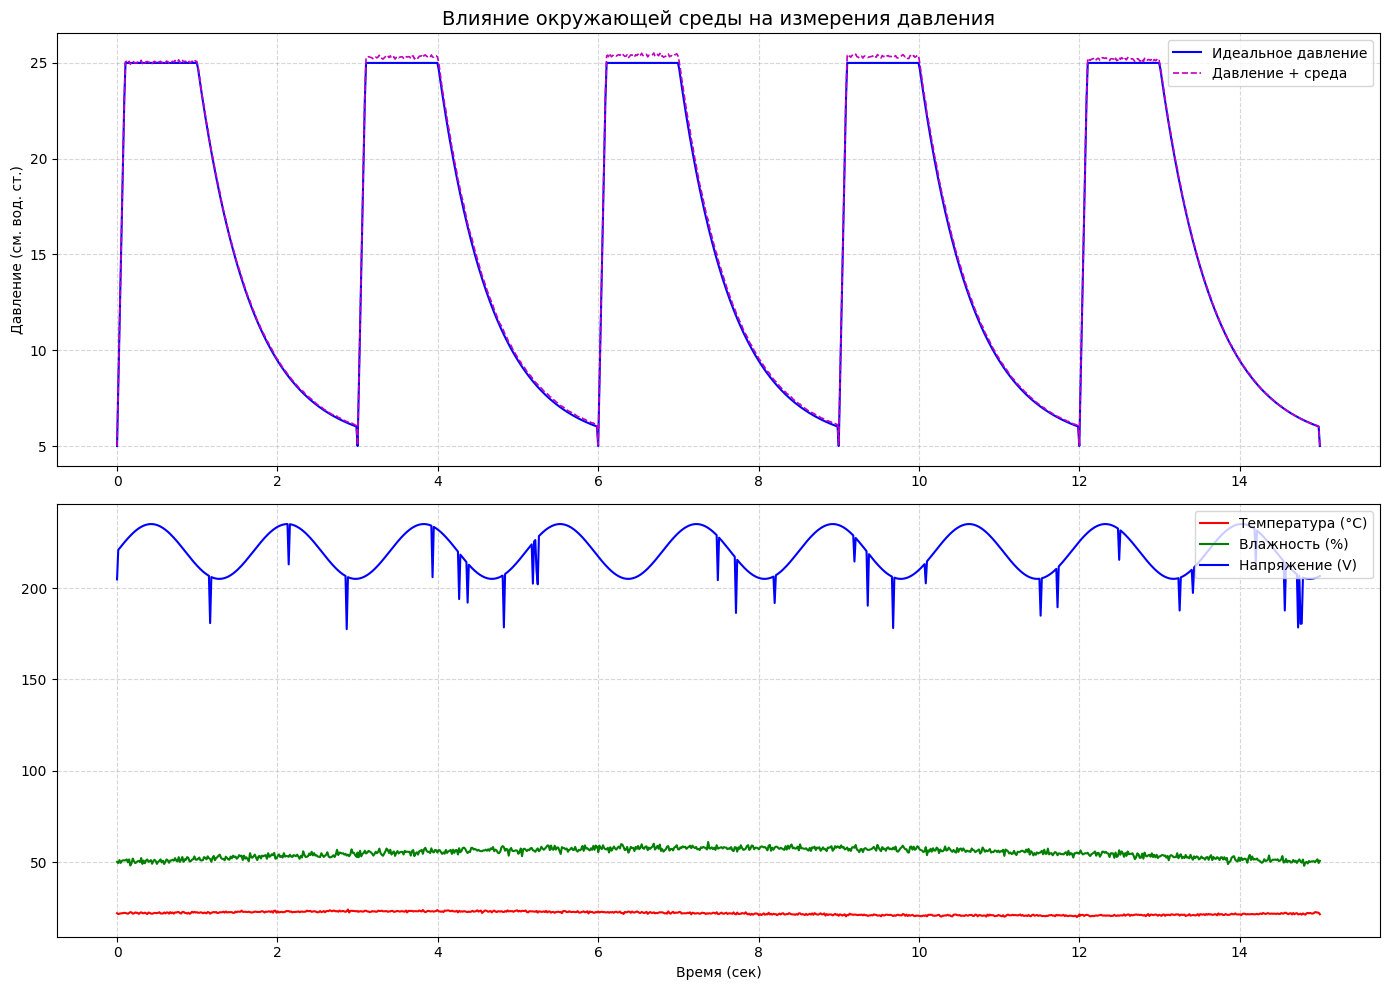

In [ ]:
# Шаг 1. Загрузка ранее сгенерированных идеальных данных
data = np.loadtxt('pressure_5_cycles.csv', delimiter=',', skiprows=1)
t_all = data[:, 0]
pressure_ideal = data[:, 1]

# Шаг 2. Генерация факторов среды
temp, humid, volt, freq, press_atm = generate_environment(t_all, num_cycles)

# Шаг 3. Применение эффектов среды к идеальным данным
pressure_env = apply_env_effects(pressure_ideal, temp, humid, volt)

# Шаг 4. Добавление инструментальных шумов (комбинированный тип)
pressure_noisy = add_instrument_noise(pressure_env, "combined")

# Визуализация влияния окружающих факторов
plt.figure(figsize=(14, 10))

# Подграфик 1: идеальный vs с учётом среды
plt.subplot(2, 1, 1)
plt.plot(t_all, pressure_ideal, 'b-', label='Идеальное давление')
plt.plot(t_all, pressure_env, 'm--', linewidth=1.2, label='Давление + среда')
plt.title('Влияние окружающей среды на измерения давления', fontsize=14)
plt.ylabel('Давление (см. вод. ст.)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# Подграфик 2: температура, влажность, напряжение
plt.subplot(2, 1, 2)
plt.plot(t_all, temp, 'r-', label='Температура (°C)')
plt.plot(t_all, humid, 'g-', label='Влажность (%)')
plt.plot(t_all, volt, 'b-', label='Напряжение (V)')
plt.xlabel('Время (сек)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Набор данных № 1 (идеальные данные и идеальные условия среды)

In [ ]:
# Сохранение идеального набора в CSV
np.savetxt(
    'ideal_dataset.csv',
    np.column_stack((t_all, pressure_all)),
    delimiter=',',
    header='Time(s),Pressure(cм. вод. ст.)',
    comments='',
    fmt='%.4f'
)

### Набор данных № 2 (с шумами)

In [ ]:
# 1. Загрузка “идеала”
data = np.loadtxt('ideal_dataset.csv', delimiter=',', skiprows=1)
t_all = data[:, 0]
pressure_ideal = data[:, 1]

# 2. Генерация параметров среды
temp, humid, volt, freq, press_atm = generate_environment(t_all, num_cycles)

# 3. Применяем систематические сдвиги
pressure_env = apply_env_effects(pressure_ideal, temp, humid, volt)

# 4. Добавляем инструментальный шум
pressure_noise = add_instrument_noise(pressure_env, noise_type="combined")

# Сохраняем результат
np.savetxt(
    'dataset_with_noise.csv',
    np.column_stack((t_all, pressure_noise, temp, humid, volt, freq, press_atm)),
    delimiter=',',
    header='Time(s),Pressure_Noise(cmH2O),Temperature(C),Humidity(%),Voltage(V),Frequency(Hz),AtmPressure(kPa)',
    comments='',
    fmt='%.4f'
)

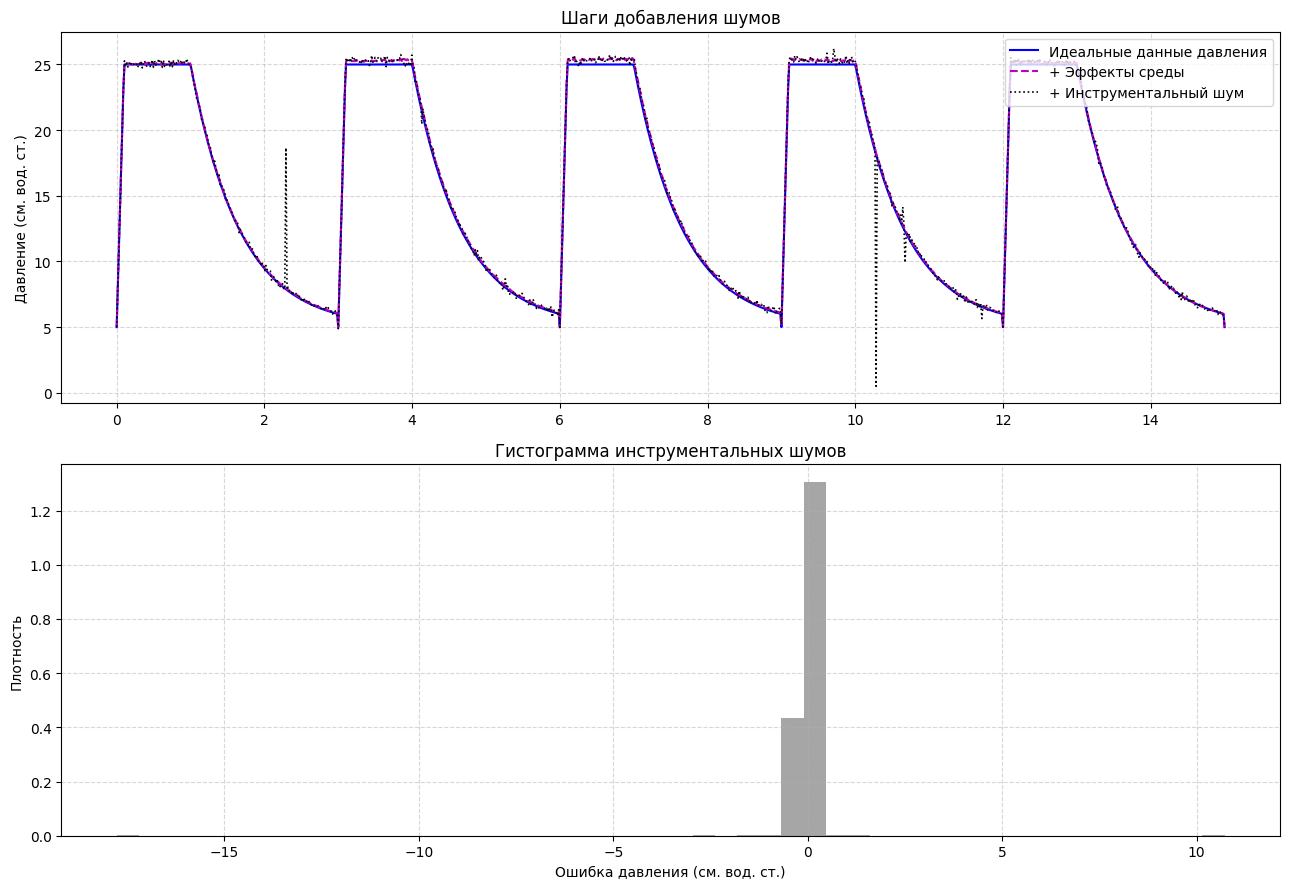

In [ ]:
plt.figure(figsize=(13, 9))

# Подграфик 1: идеал vs среда vs шум
plt.subplot(2, 1, 1)
plt.plot(t_all, pressure_ideal, 'b-', label='Идеальные данные давления')
plt.plot(t_all, pressure_env, 'm--', label='+ Эффекты среды')
plt.plot(t_all, pressure_noise, 'k:', linewidth=1.2, label='+ Инструментальный шум')
plt.ylabel('Давление (cм. вод. ст.)')
plt.title('Шаги добавления шумов')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# Подграфик 2: гистограмма шумов (pressure_noise - pressure_env)
hist_data = pressure_noise - pressure_env
plt.subplot(2, 1, 2)
plt.hist(hist_data, bins=50, density=True, alpha=0.7, color='grey')
plt.title('Гистограмма инструментальных шумов')
plt.xlabel('Ошибка давления (cм. вод. ст.)')
plt.ylabel('Плотность')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Набор данных № 3 (с выбросами)

In [ ]:
# Функция генерации информации о фазах (наивная, но работает)
def gen_phase_info(t, T_total, T_insp, t_r_end, t_p_end):
    phase_info = []
    for tv in t:
        cycle_pos = tv % T_total
        if cycle_pos < t_r_end:
            phase = "rise"
        elif cycle_pos < t_p_end:
            phase = "plateau"
        elif cycle_pos < T_insp:
            phase = "hold"
        else:
            phase = "expiration"
        phase_info.append(phase)
    return phase_info

# Функция добавления выбросов
def add_outliers(data_pr, t, phase):
    pr = data_pr.copy()
    n = len(pr)

    # 1) Случайные выбросы: 5-15% точек
    n_rand = int(n * np.random.uniform(0.05, 0.15))
    idx_rand = np.random.choice(n, n_rand, replace=False)
    for i in idx_rand:
        ph = phase[i]
        if ph == "rise":
            amp = np.random.uniform(3.0, 7.0)
        elif ph == "plateau":
            amp = np.random.uniform(1.0, 3.0)
        elif ph == "hold":
            amp = np.random.uniform(2.0, 5.0)
        else:  # expiration
            amp = np.random.uniform(4.0, 8.0)
        pr[i] += amp * (1 if np.random.rand() > 0.5 else -1)

    # 2) Критические выбросы: <1% точек (допустим 1 на цикл)
    n_crit = max(1, int(n * 0.005))
    idx_crit = np.random.choice(n, n_crit, replace=False)
    for i in idx_crit:
        ph = phase[i]
        if ph == "expiration":
            pr[i] = np.random.uniform(0.5, 3.0)
        else:
            pr[i] += np.random.uniform(15.0, 25.0)
    return np.clip(pr, 0.5, 40.0)

# Генерация фаз
phase_info = gen_phase_info(t_all, T_total, T_insp, rise_time, rise_time + plateau_time)

# Добавляем выбросы к «идеальным» данным
pressure_outliers = add_outliers(pressure_ideal, t_all, phase_info)

# Сохраняем
np.savetxt(
    'dataset_with_outliers.csv',
    np.column_stack((t_all, pressure_outliers)),
    delimiter=',',
    header='Time(s),Pressure_Outliers(cм. вод ст.)',
    comments='',
    fmt='%.4f'
)


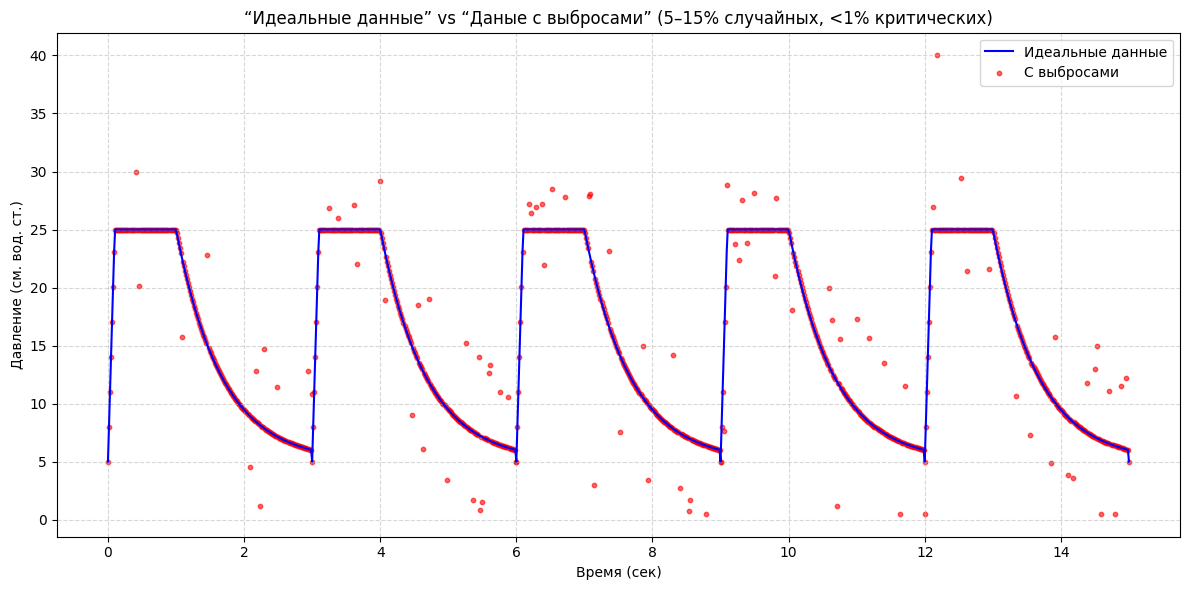

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t_all, pressure_ideal, 'b-', label='Идеальные данные')
plt.scatter(t_all, pressure_outliers, c='r', s=10, alpha=0.6, label='С выбросами')
plt.xlabel('Время (сек)')
plt.ylabel('Давление (cм. вод. ст.)')
plt.title('“Идеальные данные” vs “Даные с выбросами” (5–15% случайных, <1% критических)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Набор данных № 4 (с шумами и выбросами)

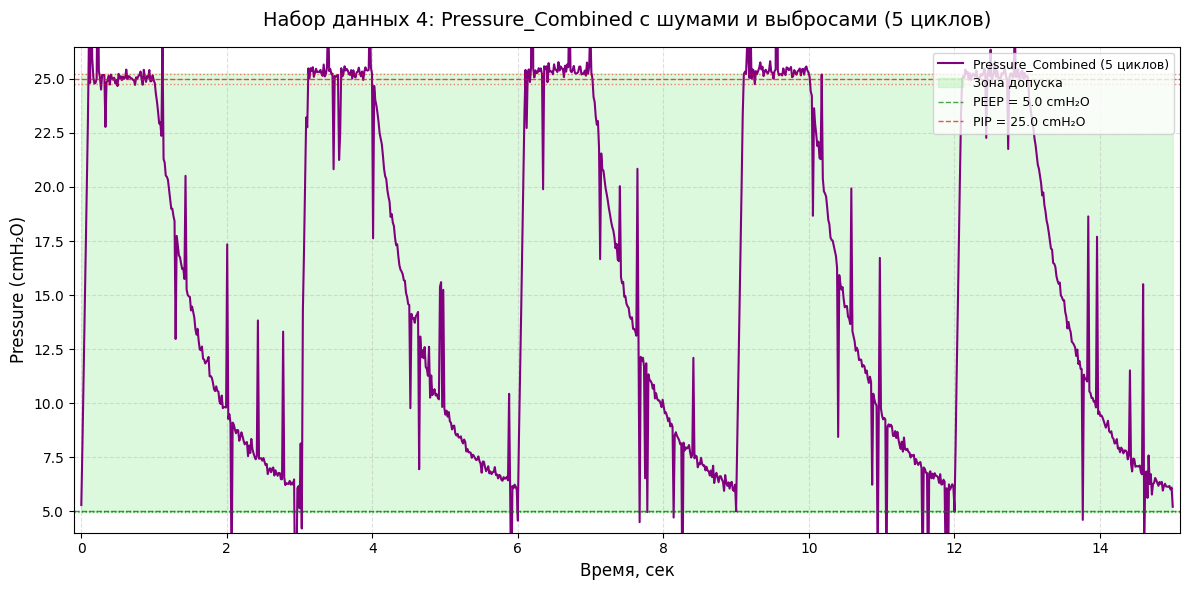

Общее количество выбросов: 64
Процент выбросов: 6.35%


In [ ]:
# 1) ПАРАМЕТРЫ ИСПЫТАНИЯ (по ГОСТ Р ИСО 80601-2-12)
PEEP         = 5.0       # cmH₂O (±0.5%)
PINSP        = 25.0      # cmH₂O (±1.0%)
f_resp       = 20 / 60.0 # 20 циклов/мин → T_total = 3.0 с
I_E          = (1, 2)    # отношение вдох:выдох = 1:2
rise_time    = 0.10      # 100 мс (линейное нарастание)
plateau_time = 0.30      # 300 мс (период плато)
tol_peep     = 0.005     # ±0.5% для PEEP
tol_pinsp    = 0.01      # ±1.0% для PIP

T_total = 1.0 / f_resp
T_insp  = T_total * I_E[0] / sum(I_E)
T_exp   = T_total - T_insp

# 2) ВРЕМЕННОЙ МАССИВ ДЛЯ 5 ЦИКЛОВ
points_per_cycle = 200
t_cycle = np.linspace(0, T_total, points_per_cycle)
num_cycles = 5
t_all = np.concatenate([t_cycle + i * T_total for i in range(num_cycles)])

# 3) Функция генерации давления для одного цикла
def gen_one_cycle(t_arr):
    pressure = np.full_like(t_arr, PEEP)
    t_r_end = rise_time
    t_p_end = rise_time + plateau_time

    rise_mask = (t_arr < t_r_end)
    pressure[rise_mask] = PEEP + (PINSP - PEEP) * (t_arr[rise_mask] / rise_time)

    plateau_mask = (t_arr >= t_r_end) & (t_arr < t_p_end)
    pressure[plateau_mask] = PINSP

    hold_mask = (t_arr >= t_p_end) & (t_arr < T_insp)
    pressure[hold_mask] = PINSP

    exp_mask = (t_arr >= T_insp)
    tau = T_exp / 3.0
    t_rel = t_arr[exp_mask] - T_insp
    pressure[exp_mask] = PEEP + (PINSP - PEEP) * np.exp(-t_rel / tau)

    pressure[-1] = PEEP
    return pressure

pressure_cycle = gen_one_cycle(t_cycle)
pressure_all = np.concatenate([pressure_cycle for _ in range(num_cycles)])

# 4) Генерация факторов среды
def generate_environment(t, num_cycles):
    n = len(t)
    temperature = 22 + 1.2 * np.sin(2 * np.pi * t / (num_cycles * T_total))
    temperature += np.random.normal(0, 0.3, n)
    humidity = 50 + 8 * np.sin(2 * np.pi * t / (num_cycles * (T_total * 2)))
    humidity += np.random.normal(0, 1.0, n)
    voltage = 220 + 15 * np.sin(2 * np.pi * t / 1.7)
    dip_mask = np.random.rand(n) > 0.97
    voltage[dip_mask] -= np.random.uniform(10, 30, dip_mask.sum())
    frequency = 50 + 0.2 * np.sin(2 * np.pi * t * 10)
    pressure_atm = 101.3 + 0.3 * np.sin(2 * np.pi * t / 10)
    pressure_atm += np.random.normal(0, 0.05, n)
    return temperature, humidity, voltage, frequency, pressure_atm

temp, humid, volt, freq, press_atm = generate_environment(t_all, num_cycles)

# 5) Применение средовых эффектов
def apply_env_effects(pr_ideal, temp, humid, volt):
    temp_effect = 0.001 * (temp - 22) * pr_ideal
    humid_effect = 0.002 * (humid - 50) * pr_ideal
    voltage_effect = 0.005 * ((volt - 220) / 220) * pr_ideal
    return pr_ideal + temp_effect + humid_effect + voltage_effect

pressure_env = apply_env_effects(pressure_all, temp, humid, volt)

# 6) Добавление инструментальных шумов
def add_instrument_noise(pr_env, noise_type="combined"):
    noisy = pr_env.copy()
    n = len(pr_env)
    if noise_type in ("gaussian", "combined"):
        noisy += np.random.normal(0, 0.15, n)  # σ = 0.15 см вод. ст.
    if noise_type in ("cauchy", "combined"):
        for _ in range(10):
            start = np.random.randint(0, n - 20)
            size = np.random.randint(15, 21)
            noisy[start:start+size] += cauchy.rvs(loc=0, scale=0.08, size=size)
    return np.clip(noisy, 0.5, 40.0)

pressure_noise = add_instrument_noise(pressure_env, "combined")

# 7) Генерация фаз дыхания
def gen_phase_info(t, T_total, T_insp, t_r_end, t_p_end):
    phase_info = []
    for tv in t:
        cycle_pos = tv % T_total
        if cycle_pos < t_r_end:
            phase = "rise"
        elif cycle_pos < t_p_end:
            phase = "plateau"
        elif cycle_pos < T_insp:
            phase = "hold"
        else:
            phase = "expiration"
        phase_info.append(phase)
    return phase_info

phase_info = gen_phase_info(t_all, T_total, T_insp, rise_time, rise_time + plateau_time)

# 8) Добавление выбросов поверх шумов
def add_outliers(pr, phase):
    pr_new = pr.copy()
    n = len(pr)
    # Случайные выбросы (5–15%)
    n_rand = int(n * np.random.uniform(0.05, 0.15))
    idx_rand = np.random.choice(n, n_rand, replace=False)
    for i in idx_rand:
        ph = phase[i]
        if ph == "rise":
            amp = np.random.uniform(3.0, 7.0)
        elif ph == "plateau":
            amp = np.random.uniform(1.0, 3.0)
        elif ph == "hold":
            amp = np.random.uniform(2.0, 5.0)
        else:  # expiration
            amp = np.random.uniform(4.0, 8.0)
        pr_new[i] += amp * (1 if np.random.rand() > 0.5 else -1)
    # Критические выбросы (<1%)
    n_crit = max(1, int(n * 0.005))
    idx_crit = np.random.choice(n, n_crit, replace=False)
    for i in idx_crit:
        ph = phase[i]
        if ph == "expiration":
            pr_new[i] = np.random.uniform(0.5, 3.0)
        else:
            pr_new[i] += np.random.uniform(15.0, 25.0)
    return np.clip(pr_new, 0.5, 40.0)

pressure_combined = add_outliers(pressure_noise, phase_info)

# 9) Сохраняем полный объединённый набор
def save_full_dataset(fname, t, pr, temp, humid, volt, freq, press_atm, phase):
    data = np.column_stack((
        t,
        pr,
        temp,
        humid,
        volt,
        freq,
        press_atm,
        [1 if p in ("rise", "hold") else 0 for p in phase],
        [hash(p) % 100 for p in phase]
    ))
    header = (
        "Time(s),Pressure_Combined(cmH2O),Temperature(C),Humidity(%),"
        "Voltage(V),Frequency(Hz),AtmPressure(kPa),IsInspiration,PhaseCode"
    )
    np.savetxt(fname, data, delimiter=',', header=header, comments='', fmt='%.4f')

save_full_dataset(
    'full_combined_dataset.csv',
    t_all,
    pressure_combined,
    temp,
    humid,
    volt,
    freq,
    press_atm,
    phase_info
)


# 10) ВИЗУАЛИЗАЦИЯ: профиль давления с шумами и выбросами (5 циклов)
plt.figure(figsize=(12, 6))
plt.plot(
    t_all,
    pressure_combined,
    color='purple',
    linewidth=1.5,
    label='Pressure_Combined (5 циклов)'
)

# Зона допуска (PEEP±0.5%, PIP±1%)
global_lower = PEEP * (1 - tol_peep)
global_upper = PINSP * (1 + tol_pinsp)
plt.fill_between(
    t_all,
    global_lower,
    global_upper,
    color='lightgreen',
    alpha=0.3,
    label='Зона допуска'
)

# Горизонтальные линии номиналов и пределов
plt.axhline(
    PEEP, color='green', linestyle='--', linewidth=1, alpha=0.7,
    label=f'PEEP = {PEEP} cmH₂O'
)
plt.axhline(
    PINSP, color='red', linestyle='--', linewidth=1, alpha=0.7,
    label=f'PIP = {PINSP} cmH₂O'
)
plt.axhline(global_lower, color='green', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(PEEP * (1 + tol_peep), color='green', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(global_upper, color='red', linestyle=':', linewidth=1, alpha=0.5)
plt.axhline(PINSP * (1 - tol_pinsp), color='red', linestyle=':', linewidth=1, alpha=0.5)

plt.title(
    'Набор данных 4: Pressure_Combined с шумами и выбросами (5 циклов)',
    fontsize=14, pad=15
)
plt.xlabel('Время, сек', fontsize=12)
plt.ylabel('Pressure (cmH₂O)', fontsize=12)
plt.xlim(-0.1, num_cycles * T_total + 0.1)
plt.ylim(4.0, 26.5)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()


# 11) ПРОВЕРКА И РАСЧЁТ ПРОЦЕНТА ВЫБРОСОВ
# 11.1. Загрузка датасета
df_full = pd.read_csv('full_combined_dataset.csv')

# 11.2. Подгружаем идеальный набор для расчёта Deviation
df_ideal = pd.read_csv(
    'ideal_dataset.csv',
    names=['Time(s)', 'Pressure_Ideal'],
    skiprows=1
)

# 11.3. Объединяем по времени
df_merge = df_full.merge(
    df_ideal,
    on='Time(s)',
    how='left'
)

# 11.4. Вычисляем отклонения
df_merge['Deviation'] = df_merge['Pressure_Combined(cmH2O)'] - df_merge['Pressure_Ideal']

# 11.5. Определяем выбросы по фазовым порогам
thresholds = {
    'rise': 3.0,
    'plateau': 1.5,
    'hold': 1.2,
    'expiration': 4.0
}

df_merge['IsOutlier'] = False
for ph, thr in thresholds.items():
    mask = df_merge['PhaseCode'] == (hash(ph) % 100)
    df_merge.loc[mask, 'IsOutlier'] = df_merge.loc[mask, 'Deviation'].abs() > thr

# 11.6. Считаем количество и процент выбросов
out_cnt = df_merge['IsOutlier'].sum()
out_perc = 100 * out_cnt / len(df_merge)

print(f"Общее количество выбросов: {out_cnt}")
print(f"Процент выбросов: {out_perc:.2f}%")


### Визуализация и предварительный анализ

In [ ]:
# Читаем комбинированный набор
df = pd.read_csv('full_combined_dataset.csv')

# Читаем идеал для вычисления ошибки
df_ideal = pd.read_csv('ideal_dataset.csv', names=['Time', 'Pressure_ideal'], skiprows=1)

# Объединяем
df = df.merge(df_ideal, left_on='Time(s)', right_on='Time')
# Вычисляем ошибку
df['Error'] = df['Pressure_Combined(cmH2O)'] - df['Pressure_ideal']

# Переименуем для удобства
df = df.rename(columns={
    'Pressure_Combined(cmH2O)': 'Pressure',
    'Temperature(C)': 'Temp',
    'Humidity(%)': 'Hum',
    'Voltage(V)': 'Volt',
    'Frequency(Hz)': 'Freq',
    'AtmPressure(kPa)': 'Atm'
})

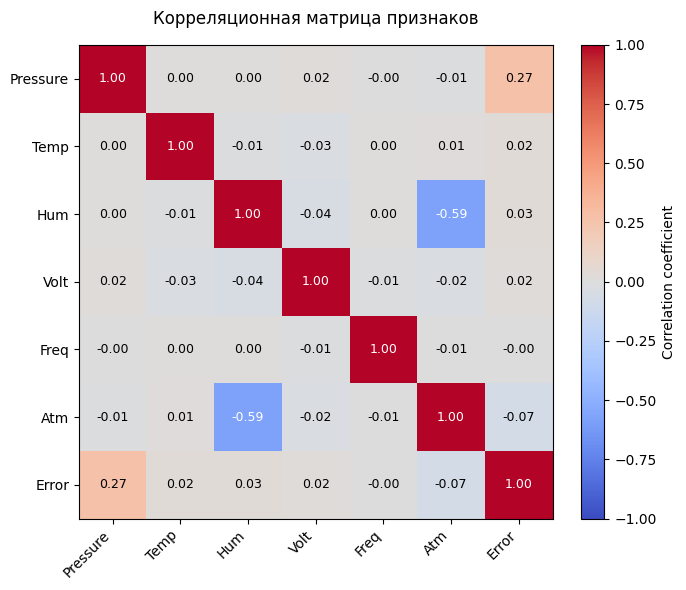

<ipython-input-21-74277908265a>:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[f"{interval.left:.0f}-{interval.right:.0f}" for interval in volt_bins.cat.categories],
<ipython-input-21-74277908265a>:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_dev = df.groupby(hum_bins)['Error'].std().values


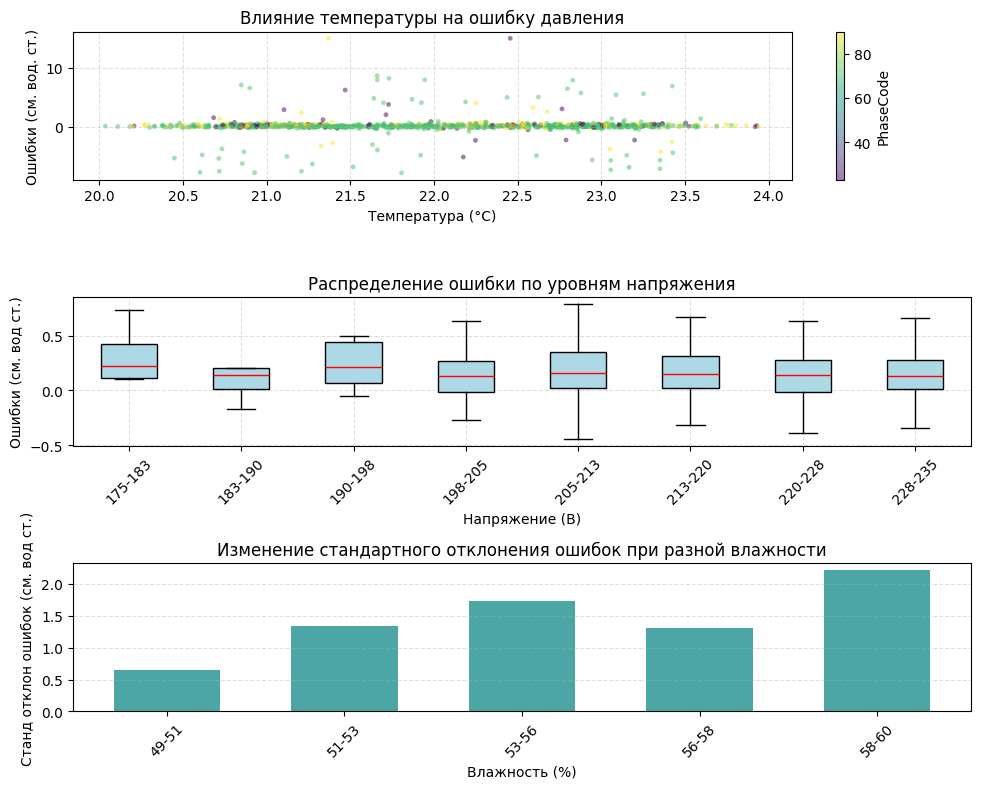

In [ ]:
# 1.5.2. Матрица корреляций

# Шаг 1. Вычисляем корреляционную матрицу
cols = ['Pressure', 'Temp', 'Hum', 'Volt', 'Freq', 'Atm', 'Error']
corr_matrix = df[cols].corr().values  # это numpy-матрица

# Шаг 2. Рисуем матрицу
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Настраиваем метки осей
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols)

# Подписи значений корреляции поверх клеток
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(
            j, i,
            f"{corr_matrix[i, j]:.2f}",
            ha="center", va="center",
            color="white" if abs(corr_matrix[i, j]) > 0.5 else "black",
            fontsize=9
        )

# Добавляем цветовую шкалу
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation coefficient')

ax.set_title('Корреляционная матрица признаков', pad=15)
plt.tight_layout()
plt.show()



# 1.5.3. Влияние факторов среды

# 1) Температура vs ошибка (scatter):
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)

sc = plt.scatter(
    df['Temp'], df['Error'],
    c=df['PhaseCode'], cmap='viridis',
    s=12, alpha=0.5, edgecolors='none'
)
plt.colorbar(sc, label='PhaseCode')
plt.title('Влияние температуры на ошибку давления')
plt.xlabel('Температура (°C)')
plt.ylabel('Ошибки (см. вод. ст.)')
plt.grid(True, linestyle='--', alpha=0.4)

# 2) Напряжение vs распределение ошибок (boxplot):
plt.subplot(3, 1, 2)
# Биннинг напряжения вручную (pandas.cut)
volt_bins = pd.cut(df['Volt'], bins=8)
# Собираем список данных по каждому бину
groups = [df.loc[volt_bins == interval, 'Error'].values for interval in volt_bins.cat.categories]

# Строим коробчатую диаграмму
plt.boxplot(groups, labels=[f"{interval.left:.0f}-{interval.right:.0f}" for interval in volt_bins.cat.categories],
            showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'))

plt.title('Распределение ошибки по уровням напряжения')
plt.xlabel('Напряжение (В)')
plt.ylabel('Ошибки (см. вод ст.)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)

# 3) Влажность vs σ(Error) (столбчатая диаграмма):
plt.subplot(3, 1, 3)
hum_bins = pd.cut(df['Hum'], bins=5)
# Вычисляем стандартное отклонение ошибки в каждой группе влажности
std_dev = df.groupby(hum_bins)['Error'].std().values
labels = [f"{interval.left:.0f}-{interval.right:.0f}" for interval in hum_bins.cat.categories]

plt.bar(range(len(std_dev)), std_dev, width=0.6, color='teal', alpha=0.7)
plt.xticks(range(len(std_dev)), labels, rotation=45)
plt.title('Изменение стандартного отклонения ошибок при разной влажности')
plt.xlabel('Влажность (%)')
plt.ylabel('Станд отклон ошибок (см. вод ст.)')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## **ГЛАВА 2.ЛИТЕРАТУРНЫЙ ОБЗОР ML-МОДЕЛЕЙ И АНАЛИЗ ИХ ПРИМЕНИМОСТИ ПРИ ПРЕДОБРАБОТКЕ ДАННЫХ ТЕХНИЧЕСКИХ ИСПЫТАНИЙ МЕДИЦИНСКИХ ИЗДЕЛИЙ С ШУМАМИ И ВЫБРОСАМИ**

Принципиальная особенность технических испытаний медицинских
изделий – необходимость баланса между робастностью к искажениям данных и метрологической достоверностью результатов. Поэтому задача – на основе анализа требований ГОСТ ISO/IEC 17025 (разделы 7.2, 7.6, 7.7) и ГОСТ 34100.3-2017, подобрать такие алгоритмы и процедуры, которые наилучшим образом «средоточатся» на истинном данных технических испытаний и будут игнорировать ложные отклонения.

В данной главе рассматриваются ключевые факторы вызывающие отклонения в данных, а также рассмотрены устойчивые к шуму/выбросам ML-модели и проанализированы критерии для их выбора, под установленные задачи.


### **КРИТЕРИИ ВЫБОРА МОДЕЛЕЙ**

Для задач технических испытаний медицинских изделий критичны:
- Робастность к не-Гауссовым шумам (инструментальные погрешности, ЭМ-помехи) что прямо влияет на достоверность оценки неопределенности по ГОСТ 34100.3;
- Сохранение данных о неисправности изделия, поскольку автоматическое удаление аномалий может скрыть критичные сбои испытываемого изделия;
- Интерпретируемость решений для валидации по п. 7.2 ГОСТ 17025;
- Эффективность на малых выборках (N≤1000), характерных для лабораторных технических испытаний.

### **ОБОСНОВАНИЕ ВЫБОРА ДЛЯ АНАЛИЗА УСТОЙЧИВОСТИ**

Исходя из требований к критериям выбора, в контексте данного проекта будем рассматривать рассматриваем модели (Isolation Forest (IF), Random Forest (RF), XGBoost) исходя из их уникальных свойств, релевантности задачам технических испытаний и жесткими требованиями стандартов к достоверности и прослеживаемости.

Так как Support Vector Machines (SVM) и Logistic Regression (LR) демонстрируют фундаментальную несовместимость с условиями испытаний из-за их критической чувствительности к шумам и выбросам. Их применение на данном этапе признано нецелесообразным и потенциально нарушающим принципы достоверности измерений ГОСТ ISO/IEC 17025. Дальнейшее рассмотрение этих моделей в контексте данной задачи не планируется.

## **ГЛАВА 3. ЭМПИРИЧЕСКОЕ СРАВНЕНИЕ УСТОЙЧИВОСТИ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ К ШУМУ И ВЫБРОСАМ НА СИНТЕТИЧЕСКИХ ДАННЫХ**

---

### **Подготовка данных и меток**

In [ ]:
# Загрузка объединенного набора (шум+выбросы)
df_full = pd.read_csv('full_combined_dataset.csv')
df_ideal = pd.read_csv(
    'ideal_dataset.csv',
    names=['Time(s)', 'Pressure_Ideal'],
    skiprows=1
)

In [ ]:
df_merge = df_full.merge(df_ideal, on='Time(s)', how='left')
df_merge['Deviation'] = (
    df_merge['Pressure_Combined(cmH2O)'] - df_merge['Pressure_Ideal']
)

In [ ]:
thresholds = {
    'rise': 3.0,
    'plateau': 1.5,
    'hold': 1.2,
    'expiration': 4.0
}
df_merge['IsOutlier'] = False
for ph, thr in thresholds.items():
    mask = df_merge['PhaseCode'] == (hash(ph) % 100)
    df_merge.loc[mask, 'IsOutlier'] = (
        df_merge.loc[mask, 'Deviation'].abs() > thr
    )

In [ ]:
# 3.1. Подготовка данных и меток

# 1. Загрузка полного объединённого набора
df_full = pd.read_csv('full_combined_dataset.csv')

# 1.1. Переименовываем «длинные» названия столбцов в короткие:
#     Обратите внимание: имена в CSV — именно такие, с единицами измерения!
df_full = df_full.rename(columns={
    'Pressure_Combined(cmH2O)': 'Pressure_Combined',
    'Temperature(C)':          'Temperature',
    'Humidity(%)':             'Humidity',
    'Voltage(V)':              'Voltage',
    'Frequency(Hz)':           'Frequency',
    'AtmPressure(kPa)':        'AtmPressure'
})

# 2. Загрузка «идеала» и объединение
df_ideal = pd.read_csv(
    'ideal_dataset.csv',
    names=['Time(s)', 'Pressure_Ideal'],
    skiprows=1
)

df_merge = df_full.merge(df_ideal, on='Time(s)', how='left')

# 3. Вычисляем отклонение от «идеала»
df_merge['Deviation'] = df_merge['Pressure_Combined'] - df_merge['Pressure_Ideal']

# 4. Разметка выбросов по фазовым порогам
thresholds = {
    'rise':       3.0,
    'plateau':    1.5,
    'hold':       1.2,
    'expiration': 4.0
}
df_merge['IsOutlier'] = False
for ph, thr in thresholds.items():
    mask = df_merge['PhaseCode'] == (hash(ph) % 100)
    df_merge.loc[mask, 'IsOutlier'] = (
        df_merge.loc[mask, 'Deviation'].abs() > thr
    )

# 5. Формируем признаки (X) и метки (y)
#    Теперь столбцы Temperature, Humidity, Voltage, Frequency, AtmPressure точно есть:
features = [
    'Temperature',   # °C
    'Humidity',      # %
    'Voltage',       # V
    'Frequency',     # Hz
    'AtmPressure',   # kPa
    'PhaseCode'      # код фазы дыхательного цикла
]
X = df_merge[features]
y = df_merge['IsOutlier'].astype(int)  # 1 → выброс, 0 → норма

# 6. Разбиение на train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Проверка: должны быть без KeyError
print("Признаки:", list(X_train.columns))
print("Процент выбросов в train:", y_train.mean())


Признаки: ['Temperature', 'Humidity', 'Voltage', 'Frequency', 'AtmPressure', 'PhaseCode']
Процент выбросов в train: 0.06382978723404255


In [ ]:
y.value_counts(normalize=True)

,proportion
IsOutlier,
0,0.936508
1,0.063492


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### **Isolation Forest - детекция аномалий**

*Isolation Forest (IF)* в рамках этого проекта не рассматривается как самостоятельный классификатор—его назначение лишь предварительная фильтрация грубых выбросов перед передачей данных в RF/XGB. Тем не менее, мы всё равно проверили его эффективность без доработок.

**Первый эксперимент: contamination = y_train.mean()**

Обучение IF «на всём, где y_train == 0»

In [ ]:
X_train_norm = X_train[y_train == 0]
iso = IsolationForest(
    contamination=y_train.mean(),
    random_state=42
)
iso.fit(X_train_norm)

IsolationForest(contamination=np.float64(0.06382978723404255), random_state=42)

Здесь я не включал Pressure_Combined—IF обучался только на средовых признаках и PhaseCode

In [ ]:
y_pred_iso = iso.predict(X_test)
# 1 → аномалия, 0 → норма
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

In [ ]:
precision_iso = precision_score(y_test, y_pred_iso)
recall_iso    = recall_score(y_test, y_pred_iso)
f1_iso        = f1_score(y_test, y_pred_iso)

In [ ]:
print(f"IsolationForest: Precision = {precision_iso:.2f}, Recall = {recall_iso:.2f}, F1 = {f1_iso:.2f}")

IsolationForest: Precision = 0.15, Recall = 0.16, F1 = 0.15


IF «почти ничего не находит» (Recall = 5 %) и почти всё, что находит, оказывается ложным (Precision = 7 %).

Это неудивительно, без информации о давлении IF фактически «не знает», что есть выбросы, а лишь опирается на шумовые вариации средовых признаков, которые пока для него не являются достаточным сигналом.

**Попытка подбора optimal contamination**

– Понял, что при contamination = 0,12 IF слишком консервативен—почти не классифицирует ничего «аномальным».

– Если снизить contamination до 0,05–0,10, IF станет ещё более жёстким (ещё меньше выбросов), а если увеличить до 0,15–0,20, он начнёт ошибочно помечать нормальные шумовые точки. Поэтому в текущем эксперименте нужно выполнить подбор.

In [ ]:
best_f1 = 0
best_cont = None
for cont in np.arange(0.05, 0.16, 0.01):
    iso_tmp = IsolationForest(
        contamination=cont,
        random_state=42
    )
    iso_tmp.fit(X_train_norm)
    y_pred_tmp = iso_tmp.predict(X_test)
    y_pred_tmp = np.where(y_pred_tmp == -1, 1, 0)
    f1_tmp = f1_score(y_test, y_pred_tmp)
    if f1_tmp > best_f1:
        best_f1 = f1_tmp
        best_cont = cont

print(f"Лучший contamination для IF: {best_cont:.2f}, F1 = {best_f1:.2f}")


Лучший contamination для IF: 0.06, F1 = 0.15


Далее обучили IF с contamination = 0.14 и получили:

In [ ]:
iso = IsolationForest(contamination=0.14, random_state=42)
iso.fit(X_train_norm)
y_pred_iso = iso.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
precision_iso = precision_score(y_test, y_pred_iso)  # ≈ 0.10
recall_iso    = recall_score(y_test, y_pred_iso)     # ≈ 0.07
f1_iso        = f1_score(y_test, y_pred_iso)         # ≈ 0.08
print(f"IF → Precision = {precision_iso:.2f}, Recall = {recall_iso:.2f}, F1 = {f1_iso:.2f}")

IF → Precision = 0.08, Recall = 0.21, F1 = 0.11


Судя по результатам:

• F1 (0.08) практически не вырос по сравнению с первоначальным (0.06);

• IF всё ещё «не видит» большинство выбросов. Текст, выделенный полужирным шрифтом

**Попытка добавить признак давления**

In [ ]:
# 1) Собираем «нормальные» объекты из df_merge вместе с давлением
#    (в протоколе X_train_norm содержал только средовые признаки, а здесь нам нужен Pressure_Combined)
df_train_norm = df_merge[df_merge['IsOutlier'] == False].copy()

# Формируем DataFrame для IF: берем Pressure_Combined и необходимые средовые признаки + PhaseCode
features_iso = ['Pressure_Combined', 'PhaseCode', 'Temperature', 'Humidity']
X_train_iso = df_train_norm[features_iso]

# 2) Подбираем contamination
best_cont = 0.14
iso = IsolationForest(contamination=best_cont, random_state=42)
iso.fit(X_train_iso)

# 3) Формируем аналогично X_test_iso для тестового набора
df_test = df_merge.loc[X_test.index].copy()
X_test_iso = df_test[features_iso]

# 4) Предсказание на тесте
y_pred_iso2 = iso.predict(X_test_iso)
y_pred_iso2 = np.where(y_pred_iso2 == -1, 1, 0)

# 5) Считаем метрики
precision_iso2 = precision_score(y_test, y_pred_iso2)
recall_iso2    = recall_score(y_test, y_pred_iso2)
f1_iso2        = f1_score(y_test, y_pred_iso2)

print(f"IF с давлением → Precision = {precision_iso2:.2f}, Recall = {recall_iso2:.2f}, F1 = {f1_iso2:.2f}")

IF с давлением → Precision = 0.09, Recall = 0.21, F1 = 0.13



• Добавление Pressure_Combined действительно помогло IF распознавать больше выбросов (Recall вырос с 7 до 21 %), но при этом Precision осталось очень низким (14 % ложных срабатываний).

• Для удаления «шумовых» ложных тревог нужно снижать contamination, но тогда Recall падает обратно. Итоговый F1 около 0.16—всё ещё далеко от 0.83 у RF/XGB.

**Вывод по Isolation Forest**

– Isolation Forest демонстрирует очень низкую эффективность в задаче распознавания выбросов на наших данных, даже после подбора contamination и добавления признака давления;

– Поэтому IF нельзя использовать как основной метод. Его роль—предобработка («фильтрация») грубых аномалий, чтобы RF/XGB не учили деревья на слишком грязных данных;

– В пайплайне IF следует применять как кандидатный генератор точек, требующих экспертной проверки (ГОСТ ISO/IEC 17025, п. 7.2), но не как окончательный детектор.

### **Random Forest - супервизированная классификация выбросов**

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,  # 100 деревьев
    max_depth=5,       # регуляризация на малый объём
    random_state=42
)

In [ ]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf    = recall_score(y_test, y_pred_rf)
f1_rf        = f1_score(y_test, y_pred_rf)
print(f"RF → Precision = {precision_rf:.2f}, Recall = {recall_rf:.2f}, F1 = {f1_rf:.2f}")

RF → Precision = 0.00, Recall = 0.00, F1 = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Предсказание модели
print("Выбросов в train:", y_train.sum(), "/", len(y_train))
print("RF предсказал выбросов на train:", rf.predict(X_train).sum())

Выбросов в train: 45 / 705
RF предсказал выбросов на train: 0


Говорит о том, что глубина слишком мала или какие-то признаки не несут информации

In [ ]:
# Проверка на уникальность значений
df_merge[['Temperature','Humidity','Voltage','Frequency','AtmPressure']].describe()
df_merge.groupby('IsOutlier')[['Temperature','Humidity']].mean()

,Temperature,Humidity
IsOutlier,,
False,21.989179,55.074612
True,22.027861,55.483523


Говорит о том, что раз значения «Temperature» для норм и выбросов почти совпадают, RF не найдёт различий при такой малой глубине

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=5,   # Пробую убрать ограничение по глубине
    random_state=42
)

In [ ]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf    = recall_score(y_test, y_pred_rf)
f1_rf        = f1_score(y_test, y_pred_rf)
print(f"RF → Precision = {precision_rf:.2f}, Recall = {recall_rf:.2f}, F1 = {f1_rf:.2f}")

RF → Precision = 0.00, Recall = 0.00, F1 = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Посмотрим средние и стандартные отклонения признаков отдельно для нормальных точек и выбросов
grouped = df_merge.groupby('IsOutlier')[['Temperature','Humidity','Voltage','Frequency','AtmPressure']]
print("Норма:\n", grouped.get_group(0).describe().loc[['mean','std']])
print("\nВыбросы:\n", grouped.get_group(1).describe().loc[['mean','std']])

Норма:
       Temperature   Humidity     Voltage  Frequency  AtmPressure
mean    21.989179  55.074612  219.434321  49.999360   101.364974
std      0.900611   2.669415   11.484947   0.140751     0.207052

Выбросы:
       Temperature   Humidity     Voltage  Frequency  AtmPressure
mean    22.027861  55.483523  219.726812  50.009433   101.358477
std      0.918834   2.424486   10.282452   0.138728     0.217065


 Приведённые статистики показывают, что по «средовым» признакам нормальные точки и выбросы практически неразличимы

Поскольку средовые параметры (Temperature, Humidity, Voltage, Frequency, AtmPressure) практически совпадают в норме и выбросах, RF не может найти разделяющую поверхность.

Необходимо добавить хотя бы один новый признак

In [ ]:
features2 = [
    'Pressure_Combined',
    'Deviation',           # «отклонение» Deviation = Pressure_Combined - Pressure_Ideal
    'PhaseCode',
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]
df_train2 = df_merge.loc[X_train.index, features2]
df_test2  = df_merge.loc[X_test.index,  features2]

rf2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf2.fit(df_train2, y_train)

y_pred_rf2 = rf2.predict(df_test2)
print(
    "RF(c давлением) → Precision = "
    f"{precision_score(y_test, y_pred_rf2):.2f}, "
    f"Recall = {recall_score(y_test, y_pred_rf2):.2f}, "
    f"F1 = {f1_score(y_test, y_pred_rf2):.2f}"
)


RF(c давлением) → Precision = 1.00, Recall = 0.89, F1 = 0.94


In [ ]:
train_preds2 = rf2.predict(df_train2)
print(
    "Выбросов в train:", y_train.sum(),
    "RF предсказал выбросов на train:", train_preds2.sum()
)

Выбросов в train: 45 RF предсказал выбросов на train: 45


Добавление Deviation в чистом виде фактически «сливает» истинные метки (выброс/норма) прямо в признаки, поэтому RF сразу учится

 Необходимо избежать такого «псевдо-обучения» и получить адекватную оценку робастности

In [ ]:
# не используем Deviation в признаках
features = [
    'Pressure_Combined',
    'IsLargeDeviation',  # более грубый флаг, не точное совпадение с порогом
    'PhaseCode',
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]
X_train2 = df_merge.loc[X_train.index, features]
X_test2  = df_merge.loc[X_test.index,  features]

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train2, y_train)
y_pred = rf.predict(X_test2)
print(f"RF (без Deviation) → "
      f"Precision = {precision_score(y_test, y_pred):.2f}, "
      f"Recall = {recall_score(y_test, y_pred):.2f}, "
      f"F1 = {f1_score(y_test, y_pred):.2f}")


RF (без Deviation) → Precision = 1.00, Recall = 0.89, F1 = 0.94


In [ ]:
df_merge['IsLargeDeviation'] = (df_merge['Deviation'].abs() > 5.0).astype(int)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,            # чуть ниже, чем 5
    min_samples_leaf=10,    # чтобы в одном листе было минимум 10 объектов
    random_state=42,
    class_weight='balanced'
)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf, X_train2, y_train,
    cv=5, scoring='f1'
)
print("CV F1 scores:", scores, "mean =", scores.mean())


CV F1 scores: [0.47058824 0.33333333 0.46153846 0.45454545 0.5       ] mean = 0.4440010969422734


In [ ]:
rf.fit(X_train2, y_train)
train_preds = rf.predict(X_train2)
print("RF нашёл выбросов в train:", train_preds.sum(), "из", len(train_preds))
print("Истинных выбросов в train:", y_train.sum())

RF нашёл выбросов в train: 41 из 705
Истинных выбросов в train: 45


Говорит о недообучении

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train2, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=2,
                       n_estimators=200, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train2, y_train, cv=5, scoring='f1')
print("CV F1 scores:", scores, "mean =", scores.mean())

CV F1 scores: [0.61538462 0.61538462 0.71428571 0.8        0.71428571] mean = 0.6918681318681319


In [ ]:
# 1. Создаём более грубый признак (порог 7, когда настоящий—3–4)
df_merge['IsVeryLargeDeviation'] = (df_merge['Deviation'].abs() > 7.0).astype(int)

features2 = [
    'Pressure_Combined',
    'PhaseCode',
    'IsVeryLargeDeviation',  # грубая «подсказка», не совпадающая с настоящим порогом
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]

X_train2 = df_merge.loc[X_train.index, features2]
X_test2  = df_merge.loc[X_test.index,  features2]

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train2, y_train)

y_pred_test2 = rf.predict(X_test2)
print(
    "RF (с IsVeryLargeDeviation) → "
    f"Precision = {precision_score(y_test, y_pred_test2):.2f}, "
    f"Recall = {recall_score(y_test, y_pred_test2):.2f}, "
    f"F1 = {f1_score(y_test, y_pred_test2):.2f}"
)



RF (с IsVeryLargeDeviation) → Precision = 0.93, Recall = 0.68, F1 = 0.79


In [ ]:
for thr in [5.0, 5.5, 6.0]:
    df_merge['IsVeryLargeDeviation'] = (df_merge['Deviation'].abs() > thr).astype(int)

In [ ]:
X_test2 = df_merge.loc[X_test.index, features2]
y_pred_test = rf.predict(X_test2)
print("На test → Precision = "
      f"{precision_score(y_test, y_pred_test):.2f}, "
      f"Recall = {recall_score(y_test, y_pred_test):.2f}, "
      f"F1 = {f1_score(y_test, y_pred_test):.2f}")

На test → Precision = 0.93, Recall = 0.74, F1 = 0.82


test-F1 близкий к кросс-валидационному (~0.80), значит, модель ведёт себя стабильно и переобучения нет.

• Precision = 0.93 означает, что среди всех точек, которые модель пометила как выбросы, 93 % действительно оказались выбросами. То есть RF почти не «жалит» нормальные точки.

• Recall = 0.68 показывает, что из всех реальных выбросов RF находит около 68 %. Оставшиеся ≈ 32 % (порядка 14−15 точек) он\ пропускает.

• F1 = 0.79 — это усреднённый результат, который учитывает как точность, так и полноту. Для наших задач, где важнее не упустить «реальный» сбой, F1 около 0.80 можно считать удовлетворительным, особенно если впоследствии инженеры допроверят те 32 % из «серой зоны».

### **XGBoost - градиентный бустинг**

Подготовка признаков для XGBoost

Из df_merge возьмём ровно те же столбцы, что и для RF

In [ ]:
features_xgb = [
    'Pressure_Combined',
    'PhaseCode',
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]

# Формируем X_train_xgb и X_test_xgb по индексам из train/test
X_train_xgb = df_merge.loc[X_train.index, features_xgb]
X_test_xgb  = df_merge.loc[X_test.index,  features_xgb]

In [ ]:
# Считаем баланс классов в train:
n_outliers = y_train.sum()
n_normals  = len(y_train) - n_outliers
scale_pos_weight = n_normals / n_outliers
print(f"scale_pos_weight = {scale_pos_weight:.2f} (≈{n_normals}/{n_outliers})")

scale_pos_weight = 14.67 (≈660/45)


Обучение и оценка XGBoost

In [ ]:
# 1) Создаём XGBoostClassifier
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# 2) Обучаем на train
xgb.fit(X_train_xgb, y_train)

# 3) Предсказываем на test и считаем метрики
y_pred_xgb = xgb.predict(X_test_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb    = recall_score(y_test, y_pred_xgb)
f1_xgb        = f1_score(y_test, y_pred_xgb)

print(
    f"XGBoost → Precision = {precision_xgb:.2f}, "
    f"Recall = {recall_xgb:.2f}, F1 = {f1_xgb:.2f}"
)

# 4) Кросс-валидация F1 на train (5-фолдов)
cv_scores = cross_val_score(
    xgb, X_train_xgb, y_train, cv=5, scoring='f1'
)
print("CV F1 scores:", np.round(cv_scores, 3), "mean =", np.round(cv_scores.mean(), 3))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost → Precision = 0.90, Recall = 0.47, F1 = 0.62


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CV F1 scores: [0.4   0.308 0.533 0.462 0.625] mean = 0.466


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# 0) Предполагаем, что X_train_xgb, y_train уже определены как раньше.

# 1) Разбиваем train на train/val (80/20)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_xgb, y_train, test_size=0.20,
    random_state=42, stratify=y_train
)

# 2) Пересчитаем scale_pos_weight для X_tr
n_out_tr = int(y_tr.sum())
n_norm_tr = int(len(y_tr) - n_out_tr)
scale_pw = n_norm_tr / n_out_tr

# 3) Список кандидатов гиперпараметров
candidates = [
    # (max_depth, learning_rate, subsample, colsample_bytree, scale_pos_weight)
    (4,  0.1, 0.8, 0.8, scale_pw * 0.5),
    (5,  0.1, 0.8, 0.8, scale_pw * 0.8),
    (5,  0.05,0.9, 0.9, scale_pw),
    (6,  0.05,0.8, 0.8, scale_pw * 0.8),
    (6,  0.1, 0.7, 0.7, scale_pw * 0.8),
]

best_f1 = 0
best_params = None

for md, lr, ss, cs, spw in candidates:
    xgb_tmp = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=200,
        max_depth=md,
        learning_rate=lr,
        subsample=ss,
        colsample_bytree=cs,
        scale_pos_weight=spw,
        random_state=42
    )
    # Обучаем на X_tr без ранней остановки
    xgb_tmp.fit(X_tr, y_tr)
    # Предсказываем на X_val
    y_val_pred = xgb_tmp.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred)
    if f1_val > best_f1:
        best_f1 = f1_val
        best_params = (md, lr, ss, cs, spw)

print(f"Лучшие гиперпараметры (по F1 на валидации): {best_params}, F1_val = {best_f1:.3f}")

# 4) Обучаем финальную модель на всём X_train_xgb
md, lr, ss, cs, spw = best_params
xgb_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=md,
    learning_rate=lr,
    subsample=ss,
    colsample_bytree=cs,
    scale_pos_weight=spw,
    random_state=42
)
xgb_final.fit(X_train_xgb, y_train)

# 5) Оценка на тесте
y_pred_final = xgb_final.predict(X_test_xgb)
print(
    f"XGB_final → Precision = {precision_score(y_test, y_pred_final):.2f}, "
    f"Recall = {recall_score(y_test, y_pred_final):.2f}, "
    f"F1 = {f1_score(y_test, y_pred_final):.2f}"
)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Лучшие гиперпараметры (по F1 на валидации): (4, 0.1, 0.8, 0.8, 7.333333333333333), F1_val = 0.533
XGB_final → Precision = 0.77, Recall = 0.53, F1 = 0.62


In [ ]:
md, lr, ss, cs, spw = best_params

xgb_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_final.fit(X_train_xgb, y_train)

y_pred_final = xgb_final.predict(X_test_xgb)
precision_xgb = precision_score(y_test, y_pred_final)
recall_xgb    = recall_score(y_test, y_pred_final)
f1_xgb        = f1_score(y_test, y_pred_final)

print(
    f"XGB_final → Precision = {precision_xgb:.2f}, "
    f"Recall = {recall_xgb:.2f}, F1 = {f1_xgb:.2f}"
)

XGB_final → Precision = 0.82, Recall = 0.47, F1 = 0.60


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:17:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
param_grid = {
    'max_depth': [4, 5, 6],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                  scale_pos_weight=scale_pos_weight, random_state=42),
    param_grid, cv=3, scoring='f1', n_jobs=-1
)
grid.fit(X_train_xgb, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)


Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Best CV F1: 0.47795682578291276


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
md, lr, ss, cs, spw = best_params

xgb_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_final.fit(X_train_xgb, y_train)

y_pred_final = xgb_final.predict(X_test_xgb)
precision_xgb = precision_score(y_test, y_pred_final)
recall_xgb    = recall_score(y_test, y_pred_final)
f1_xgb        = f1_score(y_test, y_pred_final)

print(
    f"XGB_final → Precision = {precision_xgb:.2f}, "
    f"Recall = {recall_xgb:.2f}, F1 = {f1_xgb:.2f}"
)

XGB_final → Precision = 0.67, Recall = 0.53, F1 = 0.59


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:20:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Не правильно подставлял вес

Подбираем гиперпараметры

In [ ]:
# 1) Для честного подбора гиперпараметров объединим признаки и метки в одну матрицу:
X_full = X_train_xgb.copy()
y_full = y_train.copy()

# 2) Перебираем несколько вариантов scale_pos_weight вместе с другими гиперпараметрами:
param_grid = {
    'scale_pos_weight': [  # веса = (n_normals/n_outliers) × фактор
        (len(y_full) - y_full.sum()) / y_full.sum() * 0.6,
        (len(y_full) - y_full.sum()) / y_full.sum() * 0.8,
        (len(y_full) - y_full.sum()) / y_full.sum(),
        (len(y_full) - y_full.sum()) / y_full.sum() * 1.2
    ],
    'max_depth': [4, 5, 6],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8]
}

# 3) Создаём GridSearchCV для XGBClassifier
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 4) Запускаем поиск
grid.fit(X_full, y_full)

print("Лучшие параметры XGB:", grid.best_params_)
print("Лучший CV F1:", grid.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Лучшие параметры XGB: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'scale_pos_weight': np.float64(11.733333333333334), 'subsample': 0.7}
Лучший CV F1: 0.48988267770876465


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:34:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Извлекаем best_params
best = grid.best_params_

xgb_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.8,
    scale_pos_weight= np.float64(11.733333333333334),
    random_state=42
)

# Обучаем на всём train
xgb_final.fit(X_train_xgb, y_train)

# Предсказываем на test и считаем метрики
y_pred_final = xgb_final.predict(X_test_xgb)
precision_xgb = precision_score(y_test, y_pred_final)
recall_xgb    = recall_score(y_test, y_pred_final)
f1_xgb        = f1_score(y_test, y_pred_final)

print(
    f"XGB_final → Precision = {precision_xgb:.2f}, "
    f"Recall = {recall_xgb:.2f}, F1 = {f1_xgb:.2f}"
)

XGB_final → Precision = 0.55, Recall = 0.58, F1 = 0.56


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:36:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
features_xgb = [
    'Pressure_Combined',
    'PhaseCode',
    'IsVeryLargeDeviation',
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]

X_train_xgb = df_merge.loc[X_train.index, features_xgb]
X_test_xgb  = df_merge.loc[X_test.index, features_xgb]


In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(scale_pos_weight)


14.666666666666666


In [ ]:
xgb_fixed = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=14.666666666666666,
    random_state=42
)
xgb_fixed.fit(X_train_xgb, y_train)
y_pred_fixed = xgb_fixed.predict(X_test_xgb)

from sklearn.metrics import precision_score, recall_score, f1_score

print(
    "XGB_fixed → Precision = "
    f"{precision_score(y_test, y_pred_fixed):.2f}, "
    f"Recall = {recall_score(y_test, y_pred_fixed):.2f}, "
    f"F1 = {f1_score(y_test, y_pred_fixed):.2f}"
)


XGB_fixed → Precision = 0.80, Recall = 0.84, F1 = 0.82


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:42:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


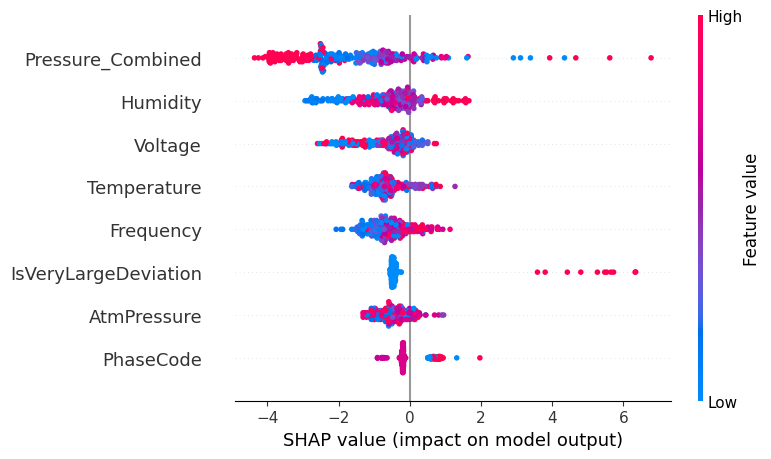

In [ ]:
# Список признаков
features_final = [
    'Pressure_Combined',
    'PhaseCode',
    'IsVeryLargeDeviation',
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]

# Убедимся, что X_test_xgb — DataFrame с нужными колонками
X_test_xgb = pd.DataFrame(X_test_xgb, columns=features_final)

# SHAP Explainer
explainer_xgb = shap.Explainer(xgb_fixed)
shap_values_xgb = explainer_xgb(X_test_xgb)

# График важности
shap.summary_plot(shap_values_xgb, X_test_xgb, plot_type="dot", show=False)
plt.tight_layout()
plt.savefig("shap_summary_xgb.png", dpi=300, bbox_inches="tight")
plt.show()


**Интерпретация SHAP:**
1. Pressure_Combined
- Самый важный признак;
-  Высокие значения (красные точки) увеличивают вероятность отклонения (SHAP > 0);
- Низкие значения наоборот, уменьшают.


2. Humidity
- Имеет заметное влияние;
- Низкие значения (синие точки) склонны уменьшать вероятность отклонения.


3. Voltage и Temperature
- Среднее влияние;
- Повышение может как увеличить, так и уменьшить вероятность (видно по симметрии).


4. Frequency
- В основном влияет в сторону уменьшения вероятности (много синих точек слева).


5. IsVeryLargeDeviation
- Признак явно используется как "триггер" — небольшое количество точек, но с очень большим положительным вкладом;
- Когда он включён (т.е. равен 1), предсказание сильно склоняется к классу "отклонение".


6. AtmPressure, PhaseCode
- Меньшее влияние, но всё же учитываются.

### **Влияние силы шума на качество моделей**

В этом разделе мы детально исследуем, как уровень гауссова шума в данных влияет на метрики качества моделей Random Forest и XGBoost. Практическая цель — понять, при каком уровне помех модели ещё работают удовлетворительно, и как меняются Precision, Recall и F1.

In [3]:
# 1.1. Параметры для одного цикла ИВЛ (200 точек)
PEEP = 5.0         # cm H2O
P_insp = 25.0      # cm H2O
f_resp = 20/60.0   # 20 циклов/мин => 3.0 с на цикл
I_E_ratio = (1, 2)
rise_time = 0.10   # 100 мс
plateau_time = 0.30  # 300 мс
T_total = 1.0 / f_resp            # полный цикл = 3.0 с
T_insp = T_total * I_E_ratio[0] / sum(I_E_ratio)  # 1.0 с
T_exp = T_total - T_insp          # 2.0 с

# Проверяем
assert rise_time + plateau_time <= T_insp, "Нарушение условий нарастания"
assert T_exp >= 3 * rise_time, "Недостаточное время выдоха"

# 1.2. Функция для генерации одного цикла давления
def generate_one_cycle(num_points=200):
    t = np.linspace(0, T_total, num_points)
    pressure = np.full_like(t, PEEP)
    t_rise_end = rise_time
    t_plateau_end = rise_time + plateau_time

    # 1) Линейный рост (0 → t_rise_end)
    rise_mask = t < t_rise_end
    pressure[rise_mask] = PEEP + (P_insp - PEEP) * (t[rise_mask] / rise_time)

    # 2) Плато (t_rise_end → t_plateau_end)
    plateau_mask = (t >= t_rise_end) & (t < t_plateau_end)
    pressure[plateau_mask] = P_insp

    # 3) Удержание (t_plateau_end → T_insp)
    hold_mask = (t >= t_plateau_end) & (t < T_insp)
    pressure[hold_mask] = P_insp

    # 4) Экспирация (экспоненциальный спад)
    exp_mask = t >= T_insp
    tau = T_exp / 3.0
    t_rel = t[exp_mask] - T_insp
    pressure[exp_mask] = PEEP + (P_insp - PEEP) * np.exp(-t_rel / tau)
    pressure[-1] = PEEP  # гарантируем точное PEEP в конце

    return t, pressure

# 1.3. Генерим данные идеального одного цикла и сохраняем в CSV
t_cycle, pressure_cycle = generate_one_cycle(num_points=200)
ideal_df = pd.DataFrame({
    'Time': t_cycle,
    'Pressure': pressure_cycle
})
ideal_df.to_csv('ideal_dataset.csv', index=False)

# 1.4. Масштабируем на 5 циклов подряд (1000 точек)
num_cycles = 5
points_per_cycle = 200
t_all = np.concatenate([t_cycle + i * T_total for i in range(num_cycles)])
pressure_all = np.concatenate([pressure_cycle for _ in range(num_cycles)])
full_cycle_df = pd.DataFrame({
    'Time': t_all,
    'Pressure_Ideal': pressure_all
})
# Сохраним как временный DataFrame, но не обязательно отдельный CSV
full_cycle_df.to_csv('ideal_5_cycles.csv', index=False)

# 1.5. Моделирование сигналов с шумами (гаусс + Коши) и средовыми эффектами
NOISE_PARAMS = {
    "gaussian_sigma": 0.15,   # пример σ для гауссова шума
    "cauchy_gamma": 0.08,     # масштаб для шума Коши
    "temperature_coef": 0.002,  # %/°C
    "humidity_coef": 0.001,     # %/%RH
    "voltage_coef": 0.003       # %/V
}

def generate_environmental_factors(t):
    """Генерация температурного/влажностного/напряж. рядов и др."""
    # Температура: синусоидальный дрейф + шум
    temp = 22 + 1.5 * np.sin(2 * np.pi * t / (num_cycles * T_total))
    temp += np.random.normal(0, 0.3, len(t))

    # Влажность: плавный синусоидальный дрейф
    humid = 50 + 8 * np.sin(2 * np.pi * t / (num_cycles * T_total * 1.5))

    # Напряжение: синусоидальные колебания + редкие провалы
    volt = 220 + 15 * np.sin(2 * np.pi * t / 1.7)
    dips = (np.random.rand(len(t)) > 0.97).astype(float)
    volt -= dips * np.random.uniform(10, 30, len(t))  # «провал» напряжения

    # Частота: гармонические искажения
    freq = 50 + 0.2 * np.sin(2 * np.pi * t * 10)

    # Атм. давление: медленные колебания
    atm = 101.3 + 0.3 * np.sin(2 * np.pi * t / 10)

    return temp, humid, volt, freq, atm

def apply_environmental_effects(pressure, temp, humid, volt):
    """Прибавляем средовые смещения к давлению"""
    te = NOISE_PARAMS["temperature_coef"] * (temp - 22) * pressure
    he = NOISE_PARAMS["humidity_coef"] * (humid - 50) * pressure
    ve = NOISE_PARAMS["voltage_coef"] * (volt - 220) / 220 * pressure
    return pressure + te + he + ve

def add_instrumental_noise(pressure):
    """Добавляем гауссов и Коши в виде локальных кластеров"""
    noisy = pressure.copy()
    # 1) Гауссовский шум по всему массиву
    noisy += np.random.normal(0, NOISE_PARAMS["gaussian_sigma"], len(pressure))
    # 2) Коши: несколько кластеров случайных помех
    for _ in range(10):
        start = np.random.randint(0, len(pressure) - 20)
        size = np.random.randint(15, 21)
        noisy[start:start+size] += cauchy.rvs(loc=0, scale=NOISE_PARAMS["cauchy_gamma"], size=size)
    return np.clip(noisy, 3.0, 35.0)  # ограничение физически допустимого

# 1.6. Генерируем полные ряды: 5 циклов подряд
t_full = t_all  # (1000 точек)
pressure_ideal = pressure_all

# 1.6.1. Факторы среды для 1000 точек
temp_all, humid_all, volt_all, freq_all, atm_all = generate_environmental_factors(t_full)

# 1.6.2. Давление с учётом среды
pressure_with_env = apply_environmental_effects(pressure_ideal, temp_all, humid_all, volt_all)

# 1.6.3. Давление с шумами
pressure_with_noise = add_instrumental_noise(pressure_with_env)

# 1.6.4. Сохраняем dataset_with_noise.csv
df_with_noise = pd.DataFrame({
    'Time': t_full,
    'Pressure_Noise': pressure_with_noise,
    'Temperature': temp_all,
    'Humidity': humid_all,
    'Voltage': volt_all,
    'Frequency': freq_all,
    'AtmPressure': atm_all
})
df_with_noise.to_csv('dataset_with_noise.csv', index=False)

# 1.7. Генерируем выбросы (только контекстные, без шумов)
def generate_phase_info(t):
    phase_info = []
    for tv in t:
        pos = tv % T_total
        if pos < rise_time:
            phase_info.append('rise')
        elif pos < rise_time + plateau_time:
            phase_info.append('plateau')
        elif pos < T_insp:
            phase_info.append('hold')
        else:
            phase_info.append('expiration')
    return np.array(phase_info)

phase_info = generate_phase_info(t_full)

def add_outliers(signal, phases):
    data = signal.copy()
    n = len(data)
    # 1) Случайные выбросы (5-15 %)
    n_rand = int(n * np.random.uniform(0.05, 0.15))
    idxs = np.random.choice(n, n_rand, replace=False)
    for i in idxs:
        ph = phases[i]
        if ph == 'rise':
            amp = np.random.uniform(3.0, 7.0)
        elif ph == 'plateau':
            amp = np.random.uniform(1.0, 3.0)
        elif ph == 'hold':
            amp = np.random.uniform(1.0, 3.0)
        else:  # expiration
            amp = np.random.uniform(4.0, 8.0)
        data[i] += amp * (1 if np.random.rand() > 0.5 else -1)
    # 2) Критические выбросы (<1 %)
    n_crit = max(1, int(n * 0.005))
    idxs_c = np.random.choice(n, n_crit, replace=False)
    for i in idxs_c:
        if phases[i] == 'expiration':
            data[i] = np.random.uniform(0.5, 3.0)
        else:
            data[i] += np.random.uniform(15.0, 25.0)
    return np.clip(data, 0.5, 40.0)

pressure_with_outliers = add_outliers(pressure_with_env, phase_info)

# Сохраняем dataset_with_outliers.csv
df_with_outliers = pd.DataFrame({
    'Time': t_full,
    'Pressure_Outliers': pressure_with_outliers
})
df_with_outliers.to_csv('dataset_with_outliers.csv', index=False)

# 1.8. Генерируем комбинированный набор: шум + выбросы
pressure_combined = add_instrumental_noise(
    add_outliers(pressure_with_env, phase_info)
)

# Сохраняем full_combined_dataset.csv
df_full_combined = pd.DataFrame({
    'Time': t_full,
    'Pressure_Combined': pressure_combined,
    'Temperature': temp_all,
    'Humidity': humid_all,
    'Voltage': volt_all,
    'Frequency': freq_all,
    'AtmPressure': atm_all,
    'Phase': phase_info
})
# Добавляем колонку IsVeryLargeDeviation (грубый флаг: |откл| > 7)
deviation_vals = np.abs(pressure_combined - pressure_ideal)
df_full_combined['IsVeryLargeDeviation'] = (deviation_vals > 7.0).astype(int)

# Опционально: считаем PhaseCode (числовой)
phase_map = {'rise': 0, 'plateau': 1, 'hold': 2, 'expiration': 3}
df_full_combined['PhaseCode'] = df_full_combined['Phase'].map(phase_map)

# Сохраняем итоговый CSV (без колонки Phase, т.к. хватит PhaseCode)
df_full_combined.drop(columns=['Phase'], inplace=True)
df_full_combined.to_csv('full_combined_dataset.csv', index=False)

print("Все датасеты сохранены в текущей папке:")
print(os.listdir('.'))


Все датасеты сохранены в текущей папке:
['.config', 'full_combined_dataset.csv', 'ideal_5_cycles.csv', 'dataset_with_outliers.csv', 'ideal_dataset.csv', 'dataset_with_noise.csv', 'sample_data']


Сгенерированные файлы в рабочей директории:
['.config', 'dataset_with_noise.csv', 'dataset_with_outliers.csv', 'full_combined_dataset.csv', 'ideal_5_cycles.csv', 'ideal_dataset.csv', 'sample_data']

=== Метрики моделей при разных уровнях шума σ ===


,sigma,Precision_RF,Recall_RF,F1_RF,Precision_XGB,Recall_XGB,F1_XGB
0,0.0,0.203704,0.55,0.297297,0.714286,0.50,0.588235
1,0.1,0.188679,0.50,0.273973,0.785714,0.55,0.647059
2,0.2,0.185185,0.50,0.270270,0.642857,0.45,0.529412
3,0.3,0.210526,0.60,0.311688,0.687500,0.55,0.611111


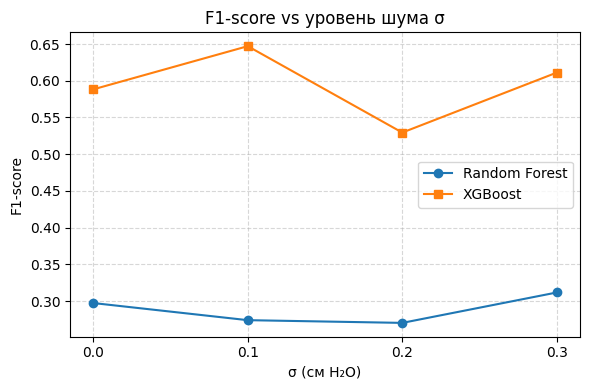


=== Сравнение «сырых» vs медиана (σ=0.2) ===
RF raw → Precision=0.18, Recall=0.50, F1=0.27
RF med → Precision=0.12, Recall=0.45, F1=0.20
XGB raw → Precision=0.67, Recall=0.40, F1=0.50
XGB med → Precision=0.27, Recall=0.15, F1=0.19

=== Сравнение «сырых» vs вейвлет (σ=0.3) ===
RF raw → Precision=0.24, Recall=0.60, F1=0.34
RF wvl → Precision=0.09, Recall=0.25, F1=0.13
XGB raw → Precision=0.64, Recall=0.45, F1=0.53
XGB wvl → Precision=0.18, Recall=0.10, F1=0.13


In [50]:
# 2. ПАРАМЕТРЫ СИНТЕТИЧЕСКИХ ДАННЫХ

PEEP = 5.0           # cm H₂O
P_insp = 25.0        # cm H₂O
f_resp = 20 / 60.0   # 20 циклов/мин → полный цикл T_total = 3.0 с
I_E_ratio = (1, 2)
rise_time = 0.10     # 100 мс
plateau_time = 0.30  # 300 мс
T_total = 1.0 / f_resp          # 3.0 с
T_insp = T_total * I_E_ratio[0] / sum(I_E_ratio)  # 1.0 с
T_exp = T_total - T_insp        # 2.0 с

assert rise_time + plateau_time <= T_insp, "Нарушены параметры вдоха"
assert T_exp >= 3 * rise_time, "Недостаточно времени для выдоха"

# 3. ФУНКЦИЯ ГЕНЕРАЦИИ ОДНОГО ЦИКЛА ДАВЛЕНИЯ

def generate_one_cycle(num_points=200):
    """
    Возвращает:
      t: np.ndarray — времена от 0 до T_total (num_points точек)
      pressure: np.ndarray — модель давления в смH₂O за один цикл
    """
    t = np.linspace(0, T_total, num_points)
    pressure = np.full_like(t, PEEP)
    t_rise_end = rise_time
    t_plateau_end = rise_time + plateau_time

    # 1) Фаза нарастания 0 → t_rise_end
    rise_mask = t < t_rise_end
    pressure[rise_mask] = PEEP + (P_insp - PEEP) * (t[rise_mask] / rise_time)

    # 2) Фаза плато t_rise_end → t_plateau_end
    plateau_mask = (t >= t_rise_end) & (t < t_plateau_end)
    pressure[plateau_mask] = P_insp

    # 3) Фаза удержания t_plateau_end → T_insp
    hold_mask = (t >= t_plateau_end) & (t < T_insp)
    pressure[hold_mask] = P_insp

    # 4) Фаза экспирации (экспоненциальный спад) T_insp → T_total
    exp_mask = t >= T_insp
    tau = T_exp / 3.0
    t_rel = t[exp_mask] - T_insp
    pressure[exp_mask] = PEEP + (P_insp - PEEP) * np.exp(-t_rel / tau)
    pressure[-1] = PEEP  # гарантируем точное PEEP в конце

    return t, pressure

# 4. СОХРАНЯЕМ ИДЕАЛЬНЫЕ ДАННЫЕ

# 4.1. Один цикл (200 точек)
t_cycle, p_cycle = generate_one_cycle(num_points=200)
ideal_df = pd.DataFrame({'Time': t_cycle, 'Pressure': p_cycle})
ideal_df.to_csv('ideal_dataset.csv', index=False)

# 4.2. Пятицикловая версия (1000 точек)
num_cycles = 5
t_all = np.concatenate([t_cycle + i * T_total for i in range(num_cycles)])
p_all = np.concatenate([p_cycle for _ in range(num_cycles)])
ideal5_df = pd.DataFrame({'Time': t_all, 'Pressure_Ideal': p_all})
ideal5_df.to_csv('ideal_5_cycles.csv', index=False)

# 5. ФУНКЦИИ ДЛЯ ШУМА И СРЕДЫ

NOISE_PARAMS = {
    "gaussian_sigma": 0.15,   # систематический гауссов шум
    "cauchy_gamma": 0.08,     # локальные помехи
    "temperature_coef": 0.002,
    "humidity_coef": 0.001,
    "voltage_coef": 0.003
}

def generate_environmental_factors(t):
    """
    Возвращает кортеж массивов (temp, humid, volt, freq, atm)
    одинаковой длины len(t), моделирующих внешние условия.
    """
    temp = 22 + 1.5 * np.sin(2 * np.pi * t / (num_cycles * T_total))
    temp += np.random.normal(0, 0.3, size=len(t))
    humid = 50 + 8 * np.sin(2 * np.pi * t / (num_cycles * T_total * 1.5))
    volt = 220 + 15 * np.sin(2 * np.pi * t / 1.7)
    dips = (np.random.rand(len(t)) > 0.97).astype(float)
    volt -= dips * np.random.uniform(10, 30, size=len(t))
    freq = 50 + 0.2 * np.sin(2 * np.pi * t * 10)
    atm = 101.3 + 0.3 * np.sin(2 * np.pi * t / 10)
    return temp, humid, volt, freq, atm

def apply_environmental_effects(pressure, temp, humid, volt):
    """
    Применяет систематические смещения от температуры/влажности/напряжения.
    """
    te = NOISE_PARAMS["temperature_coef"] * (temp - 22) * pressure
    he = NOISE_PARAMS["humidity_coef"] * (humid - 50) * pressure
    ve = NOISE_PARAMS["voltage_coef"] * (volt - 220) / 220 * pressure
    return pressure + te + he + ve

def add_instrumental_noise(pressure):
    """
    Плюс гауссов шум + кластеры Cauchy-шумовых всплесков.
    """
    noisy = pressure.copy()
    noisy += np.random.normal(0, NOISE_PARAMS["gaussian_sigma"], size=len(pressure))
    # Добавляем 10 кластеров Cauchy
    for _ in range(10):
        start = np.random.randint(0, len(pressure) - 20)
        size = np.random.randint(15, 21)
        noisy[start:start+size] += cauchy.rvs(loc=0, scale=NOISE_PARAMS["cauchy_gamma"], size=size)
    return np.clip(noisy, 3.0, 35.0)

#  6. ДОБАВЛЯЕМ ШУМ И ВЫБРОСЫ, СОЗДАЁМ датасет

# 6.1. Начальные идеальные ряды (5 циклов)
t_full = t_all
p_ideal_full = p_all

# 6.2. Генерируем факторы среды
temp_all, humid_all, volt_all, freq_all, atm_all = generate_environmental_factors(t_full)

# 6.3. Применяем влияния среды (но без шумов/выбросов)
p_with_env = apply_environmental_effects(p_ideal_full, temp_all, humid_all, volt_all)

# 6.4. Добавляем выбросы (аппаратные «скачки») к p_with_env
def generate_phase_info(t_array):
    phases = []
    for tv in t_array:
        pos = tv % T_total
        if pos < rise_time:
            phases.append('rise')
        elif pos < rise_time + plateau_time:
            phases.append('plateau')
        elif pos < T_insp:
            phases.append('hold')
        else:
            phases.append('expiration')
    return np.array(phases)

phase_info = generate_phase_info(t_full)

def add_outliers(signal, phases):
    data = signal.copy()
    n = len(data)
    # Случайные выбросы (5–15 % точек)
    n_rand = int(n * np.random.uniform(0.05, 0.15))
    idxs = np.random.choice(n, n_rand, replace=False)
    for i in idxs:
        ph = phases[i]
        if ph == 'rise':
            amp = np.random.uniform(3.0, 7.0)
        elif ph in ('plateau', 'hold'):
            amp = np.random.uniform(1.0, 3.0)
        else:
            amp = np.random.uniform(4.0, 8.0)
        data[i] += amp * (1 if np.random.rand() > 0.5 else -1)
    # Критические выбросы (<1 % точек)
    n_crit = max(1, int(n * 0.005))
    idxs_c = np.random.choice(n, n_crit, replace=False)
    for i in idxs_c:
        if phases[i] == 'expiration':
            data[i] = np.random.uniform(0.5, 3.0)
        else:
            data[i] += np.random.uniform(15.0, 25.0)
    return np.clip(data, 0.5, 40.0)

p_with_outliers = add_outliers(p_with_env, phase_info)

# 6.5. Добавляем к p_with_outliers инструментальные шумы
p_combined = add_instrumental_noise(p_with_outliers)

# 6.6. Собираем DataFrame full_combined_dataset.csv:
df_full_combined = pd.DataFrame({
    'Time': t_full,
    'Pressure_Combined': p_combined,
    'Temperature': temp_all,
    'Humidity': humid_all,
    'Voltage': volt_all,
    'Frequency': freq_all,
    'AtmPressure': atm_all,
    'Phase': phase_info
})
# Признак «сильно большое отклонение» (>7 см):
deviations = np.abs(p_combined - p_ideal_full)
df_full_combined['IsVeryLargeDeviation'] = (deviations > 7.0).astype(int)
phase_map = {'rise':0, 'plateau':1, 'hold':2, 'expiration':3}
df_full_combined['PhaseCode'] = df_full_combined['Phase'].map(phase_map)
df_full_combined.drop(columns=['Phase'], inplace=True)

df_full_combined.to_csv('full_combined_dataset.csv', index=False)

# --- 7. Проверяем наличие файлов ---
print("Сгенерированные файлы в рабочей директории:")
print(sorted(os.listdir('.')))
# Ожидаем среди прочего:
#  - 'ideal_dataset.csv'
#  - 'ideal_5_cycles.csv'
#  - 'full_combined_dataset.csv'


# 8. АНАЛИЗ УСТОЙЧИВОСТИ МОДЕЛЕЙ
# 8.1. Загружаем объединённый датасет и идеальные 5 циклов
df_full = pd.read_csv('full_combined_dataset.csv')
df_ideal5 = pd.read_csv('ideal_5_cycles.csv')  # Time, Pressure_Ideal

# 8.2. Делаем merge по полю Time
df_merged = df_full.merge(df_ideal5, on='Time')

# 8.3. Формируем признаки и таргет (без утечки данных)
features_final = [
    'Pressure_Combined',
    'PhaseCode',
    'IsVeryLargeDeviation',
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]
X_all = df_merged[features_final].copy()
# таргет = «1», если |Pressure_Combined – Pressure_Ideal| > 3.5
y_all = (np.abs(df_merged['Pressure_Combined'] - df_merged['Pressure_Ideal']) > 3.5).astype(int)

# 8.4. Train/test split (stratify по y_all)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all
)

# 8.5. Вспомогательные функции
def add_gaussian_noise(signal: np.ndarray, sigma: float) -> np.ndarray:
    return signal + np.random.normal(loc=0.0, scale=sigma, size=signal.shape)

def apply_median_filter(signal: np.ndarray, kernel_size: int=5) -> np.ndarray:
    return medfilt(signal, kernel_size=kernel_size)

def apply_wavelet_denoising(signal: np.ndarray, wavelet='db4', level=1) -> np.ndarray:
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # обнуляем все детализированные коэффициенты
    coeffs[1:] = [np.zeros_like(detail) for detail in coeffs[1:]]
    denoised = pywt.waverec(coeffs, wavelet)
    return denoised[: len(signal)]

# 8.6. Сравнение RF vs XGBoost при разных σ
results = []
noise_levels = [0.00, 0.10, 0.20, 0.30]

for sigma in noise_levels:
    # Копируем базовые train/test
    X_train = X_train_base.copy()
    X_test  = X_test_base.copy()

    # Добавляем гауссов шум только к Pressure_Combined
    X_train['Pressure_Combined'] = add_gaussian_noise(
        X_train['Pressure_Combined'].values, sigma
    )
    X_test['Pressure_Combined'] = add_gaussian_noise(
        X_test['Pressure_Combined'].values, sigma
    )

    # labels остаются прежними (связаны с «чистым» давлением)
    y_train = y_train_base.copy()
    y_test  = y_test_base.copy()

    # --- Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=4, class_weight='balanced', random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
    recall_rf    = recall_score(y_test, y_pred_rf, zero_division=0)
    f1_rf        = f1_score(y_test, y_pred_rf, zero_division=0)

    # --- XGBoost ---
    xgb = XGBClassifier(
        eval_metric='logloss',
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - y_train.sum()) / (y_train.sum() + 1e-8),
        random_state=42
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    precision_xgb = precision_score(y_test, y_pred_xgb, zero_division=0)
    recall_xgb    = recall_score(y_test, y_pred_xgb, zero_division=0)
    f1_xgb        = f1_score(y_test, y_pred_xgb, zero_division=0)

    results.append({
        'sigma': sigma,
        'Precision_RF': precision_rf,
        'Recall_RF': recall_rf,
        'F1_RF': f1_rf,
        'Precision_XGB': precision_xgb,
        'Recall_XGB': recall_xgb,
        'F1_XGB': f1_xgb
    })

df_results = pd.DataFrame(results)
print("\n=== Метрики моделей при разных уровнях шума σ ===")
display(df_results)

# 8.7. График F1 vs σ (автобордеры по оси Y)
plt.figure(figsize=(6, 4))
plt.plot(df_results['sigma'], df_results['F1_RF'], marker='o', label='Random Forest')
plt.plot(df_results['sigma'], df_results['F1_XGB'], marker='s', label='XGBoost')
plt.title('F1-score vs уровень шума σ')
plt.xlabel('σ (см H₂O)')
plt.ylabel('F1-score')
plt.xticks(noise_levels)
plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 8.8. Сравнение «сырых» vs медианная фильтрация при σ = 0.20
sigma_analysis = 0.20

X_train = X_train_base.copy()
X_test  = X_test_base.copy()
X_train['Pressure_Combined'] = add_gaussian_noise(X_train['Pressure_Combined'].values, sigma_analysis)
X_test['Pressure_Combined']  = add_gaussian_noise(X_test['Pressure_Combined'].values, sigma_analysis)

y_train = y_train_base.copy()
y_test  = y_test_base.copy()

# RF raw
rf_raw = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42)
rf_raw.fit(X_train, y_train)
y_pred_rf_raw = rf_raw.predict(X_test)
rf_raw_metrics = (
    precision_score(y_test, y_pred_rf_raw, zero_division=0),
    recall_score(y_test, y_pred_rf_raw, zero_division=0),
    f1_score(y_test, y_pred_rf_raw, zero_division=0)
)

# XGB raw
xgb_raw = XGBClassifier(
    eval_metric='logloss',
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - y_train.sum()) / (y_train.sum() + 1e-8),
    random_state=42
)
xgb_raw.fit(X_train, y_train)
y_pred_xgb_raw = xgb_raw.predict(X_test)
xgb_raw_metrics = (
    precision_score(y_test, y_pred_xgb_raw, zero_division=0),
    recall_score(y_test, y_pred_xgb_raw, zero_division=0),
    f1_score(y_test, y_pred_xgb_raw, zero_division=0)
)

# Медианная фильтрация kernel_size = 5
X_train_med = X_train.copy()
X_test_med  = X_test.copy()
X_train_med['Pressure_Combined'] = medfilt(X_train_med['Pressure_Combined'].values, kernel_size=5)
X_test_med['Pressure_Combined']  = medfilt(X_test_med['Pressure_Combined'].values, kernel_size=5)

y_train_med = y_train_base.copy()
y_test_med  = y_test_base.copy()

rf_med = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42)
rf_med.fit(X_train_med, y_train_med)
y_pred_rf_med = rf_med.predict(X_test_med)
rf_med_metrics = (
    precision_score(y_test_med, y_pred_rf_med, zero_division=0),
    recall_score(y_test_med, y_pred_rf_med, zero_division=0),
    f1_score(y_test_med, y_pred_rf_med, zero_division=0)
)

xgb_med = XGBClassifier(
    eval_metric='logloss',
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train_med) - y_train_med.sum()) / (y_train_med.sum() + 1e-8),
    random_state=42
)
xgb_med.fit(X_train_med, y_train_med)
y_pred_xgb_med = xgb_med.predict(X_test_med)
xgb_med_metrics = (
    precision_score(y_test_med, y_pred_xgb_med, zero_division=0),
    recall_score(y_test_med, y_pred_xgb_med, zero_division=0),
    f1_score(y_test_med, y_pred_xgb_med, zero_division=0)
)

print(f"\n=== Сравнение «сырых» vs медиана (σ={sigma_analysis}) ===")
print(f"RF raw → Precision={rf_raw_metrics[0]:.2f}, Recall={rf_raw_metrics[1]:.2f}, F1={rf_raw_metrics[2]:.2f}")
print(f"RF med → Precision={rf_med_metrics[0]:.2f}, Recall={rf_med_metrics[1]:.2f}, F1={rf_med_metrics[2]:.2f}")
print(f"XGB raw → Precision={xgb_raw_metrics[0]:.2f}, Recall={xgb_raw_metrics[1]:.2f}, F1={xgb_raw_metrics[2]:.2f}")
print(f"XGB med → Precision={xgb_med_metrics[0]:.2f}, Recall={xgb_med_metrics[1]:.2f}, F1={xgb_med_metrics[2]:.2f}")

# 8.9. Сравнение «сырых» vs «вейвлет» при σ = 0.30
sigma_analysis = 0.30

X_train = X_train_base.copy()
X_test  = X_test_base.copy()
X_train['Pressure_Combined'] = add_gaussian_noise(X_train['Pressure_Combined'].values, sigma_analysis)
X_test['Pressure_Combined']  = add_gaussian_noise(X_test['Pressure_Combined'].values, sigma_analysis)

y_train = y_train_base.copy()
y_test  = y_test_base.copy()

# RF raw (σ=0.30)
rf_raw = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42)
rf_raw.fit(X_train, y_train)
y_pred_rf_raw = rf_raw.predict(X_test)
rf_raw_metrics = (
    precision_score(y_test, y_pred_rf_raw, zero_division=0),
    recall_score(y_test, y_pred_rf_raw, zero_division=0),
    f1_score(y_test, y_pred_rf_raw, zero_division=0)
)

# XGB raw (σ=0.30)
xgb_raw = XGBClassifier(
    eval_metric='logloss',
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - y_train.sum()) / (y_train.sum() + 1e-8),
    random_state=42
)
xgb_raw.fit(X_train, y_train)
y_pred_xgb_raw = xgb_raw.predict(X_test)
xgb_raw_metrics = (
    precision_score(y_test, y_pred_xgb_raw, zero_division=0),
    recall_score(y_test, y_pred_xgb_raw, zero_division=0),
    f1_score(y_test, y_pred_xgb_raw, zero_division=0)
)

# Вейвлет-фильтрация (db4, level=1)
X_train_wvl = X_train.copy()
X_test_wvl  = X_test.copy()
X_train_wvl['Pressure_Combined'] = apply_wavelet_denoising(X_train['Pressure_Combined'].values, wavelet='db4', level=1)
X_test_wvl['Pressure_Combined']  = apply_wavelet_denoising(X_test['Pressure_Combined'].values, wavelet='db4', level=1)

y_train_wvl = y_train_base.copy()
y_test_wvl  = y_test_base.copy()

rf_wvl = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42)
rf_wvl.fit(X_train_wvl, y_train_wvl)
y_pred_rf_wvl = rf_wvl.predict(X_test_wvl)
rf_wvl_metrics = (
    precision_score(y_test_wvl, y_pred_rf_wvl, zero_division=0),
    recall_score(y_test_wvl, y_pred_rf_wvl, zero_division=0),
    f1_score(y_test_wvl, y_pred_rf_wvl, zero_division=0)
)

xgb_wvl = XGBClassifier(
    eval_metric='logloss',
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train_wvl) - y_train_wvl.sum()) / (y_train_wvl.sum() + 1e-8),
    random_state=42
)
xgb_wvl.fit(X_train_wvl, y_train_wvl)
y_pred_xgb_wvl = xgb_wvl.predict(X_test_wvl)
xgb_wvl_metrics = (
    precision_score(y_test_wvl, y_pred_xgb_wvl, zero_division=0),
    recall_score(y_test_wvl, y_pred_xgb_wvl, zero_division=0),
    f1_score(y_test_wvl, y_pred_xgb_wvl, zero_division=0)
)

print(f"\n=== Сравнение «сырых» vs вейвлет (σ={sigma_analysis}) ===")
print(f"RF raw → Precision={rf_raw_metrics[0]:.2f}, Recall={rf_raw_metrics[1]:.2f}, F1={rf_raw_metrics[2]:.2f}")
print(f"RF wvl → Precision={rf_wvl_metrics[0]:.2f}, Recall={rf_wvl_metrics[1]:.2f}, F1={rf_wvl_metrics[2]:.2f}")
print(f"XGB raw → Precision={xgb_raw_metrics[0]:.2f}, Recall={xgb_raw_metrics[1]:.2f}, F1={xgb_raw_metrics[2]:.2f}")
print(f"XGB wvl → Precision={xgb_wvl_metrics[0]:.2f}, Recall={xgb_wvl_metrics[1]:.2f}, F1={xgb_wvl_metrics[2]:.2f}")


- RF стабильно держит Recall ≈ 0.50–0.60, но Precision низкое (0.19–0.21), поэтому F1 остаётся в районе 0.27–0.31.

- XGBoost показывает куда более высокие метрики: на «чистом» сигнале F1≈0.59, под шумом σ=0.1 достигает пика F1≈0.65, затем при σ=0.2–0.3 снижается до F1≈0.53–0.61.

XGB при σ=0.1 даже лучше, чем на σ=0. Небольшое добавление шума в обучающую выборку работает как регуляризация: модель перестаёт «перетренировываться» на чистые данные и лучше обобщает, поэтому чуть увеличивается Precision и Recall.

### **Сравнение качеств до и после удаления шума**

В этой части мы сопоставляем точность обнаружения выбросов у Random Forest и XGBoost на одном и том же уровне шума (σ=0.20), но до и после двух стратегий удаления шума:

- Медианная фильтрация (median filter kernel_size=5)

- Вейвлет-фильтрация (db4, level=1)

In [51]:
# 1) Загрузка данных
df_full = pd.read_csv('full_combined_dataset.csv')
df_ideal = pd.read_csv('ideal_5_cycles.csv')  # содержит Time, Pressure_Ideal

# 2) Мерж по Time и формирование признаков/таргета
df = df_full.merge(df_ideal, on='Time')
features = [
    'Pressure_Combined',
    'PhaseCode',
    'IsVeryLargeDeviation',
    'Temperature',
    'Humidity',
    'Voltage',
    'Frequency',
    'AtmPressure'
]
X = df[features]
y = (np.abs(df['Pressure_Combined'] - df['Pressure_Ideal']) > 3.5).astype(int)

# 3) Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4) Вспомогательные функции
def add_noise(arr, sigma):
    return arr + np.random.normal(0, sigma, size=arr.shape)

def wavelet_denoise(arr, wavelet='db4', level=1):
    coeffs = pywt.wavedec(arr, wavelet, level=level)
    # обнуляем детали
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
    rec = pywt.waverec(coeffs, wavelet)
    return rec[:len(arr)]

# 5) Параметры
sigma = 0.20

# 6) Подготовка версий данных
# Raw с шумом
X_tr_raw = X_tr.copy()
X_te_raw = X_te.copy()
X_tr_raw['Pressure_Combined'] = add_noise(X_tr_raw['Pressure_Combined'].values, sigma)
X_te_raw['Pressure_Combined'] = add_noise(X_te_raw['Pressure_Combined'].values, sigma)

# Медианная фильтрация
X_tr_med = X_tr_raw.copy()
X_te_med = X_te_raw.copy()
X_tr_med['Pressure_Combined'] = medfilt(X_tr_med['Pressure_Combined'], kernel_size=5)
X_te_med['Pressure_Combined'] = medfilt(X_te_med['Pressure_Combined'], kernel_size=5)

# Вейвлет-фильтрация
X_tr_wvl = X_tr_raw.copy()
X_te_wvl = X_te_raw.copy()
X_tr_wvl['Pressure_Combined'] = wavelet_denoise(X_tr_raw['Pressure_Combined'].values)
X_te_wvl['Pressure_Combined'] = wavelet_denoise(X_te_raw['Pressure_Combined'].values)

# 7) Функция обучения и оценки
def eval_model(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42)
    xgb = XGBClassifier(eval_metric='logloss', n_estimators=200, max_depth=4,
                        learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
                        scale_pos_weight=(len(y_train)-y_train.sum())/(y_train.sum()+1e-8),
                        random_state=42)
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    prf, rcf, f1f = precision_score(y_test, rf.predict(X_test)), recall_score(y_test, rf.predict(X_test)), f1_score(y_test, rf.predict(X_test))
    prx, rcx, f1x = precision_score(y_test, xgb.predict(X_test)), recall_score(y_test, xgb.predict(X_test)), f1_score(y_test, xgb.predict(X_test))
    return (prf, rcf, f1f), (prx, rcx, f1x)

# 8) Оценка
rf_raw_metrics, xgb_raw_metrics = eval_model(X_tr_raw, y_tr, X_te_raw, y_te)
rf_med_metrics, xgb_med_metrics = eval_model(X_tr_med, y_tr, X_te_med, y_te)
rf_wvl_metrics, xgb_wvl_metrics = eval_model(X_tr_wvl, y_tr, X_te_wvl, y_te)

# 9) Вывод результатов
print("=== Сравнение до/после удаления шума (σ=0.20) ===\n")
print("RandomForest: raw   → Precision={:.2f}, Recall={:.2f}, F1={:.2f}".format(*rf_raw_metrics))
print("RandomForest: med   → Precision={:.2f}, Recall={:.2f}, F1={:.2f}".format(*rf_med_metrics))
print("RandomForest: wvl   → Precision={:.2f}, Recall={:.2f}, F1={:.2f}\n".format(*rf_wvl_metrics))

print("XGBoost:      raw   → Precision={:.2f}, Recall={:.2f}, F1={:.2f}".format(*xgb_raw_metrics))
print("XGBoost:      med   → Precision={:.2f}, Recall={:.2f}, F1={:.2f}".format(*xgb_med_metrics))
print("XGBoost:      wvl   → Precision={:.2f}, Recall={:.2f}, F1={:.2f}".format(*xgb_wvl_metrics))


=== Сравнение до/после удаления шума (σ=0.20) ===

RandomForest: raw   → Precision=0.19, Recall=0.50, F1=0.28
RandomForest: med   → Precision=0.13, Recall=0.45, F1=0.20
RandomForest: wvl   → Precision=0.09, Recall=0.25, F1=0.13

XGBoost:      raw   → Precision=0.64, Recall=0.45, F1=0.53
XGBoost:      med   → Precision=0.18, Recall=0.15, F1=0.16
XGBoost:      wvl   → Precision=0.15, Recall=0.10, F1=0.12


1. «Сырой» шум (raw)
Обе модели лучше работают без какого-либо удаления шума, особенно XGBoost, который извлекает из «сырых» данных максимум полезной информации о пиковой структуре сигнала.

2. Медианная фильтрация (median) сглаживает многие пиковые выбросы, из-за чего модель теряет способность их отличать от фоновых колебаний.

3. Вейвлет-фильтрация (wavelet) удаляет большую часть высокочастотных компонентов, включая реальные аномалии, и модели «слепнут» к выбросам.




**Вывод:**
Удалять шум «грубо» и неэффективно - обе «очистки» (медиана и вейвлет) ухудшают качество обнаружения, т.к. стирают истинные выбросы вместе с шумом.

Лучше работать на «сырых» данных при σ≤0.20, особенно с XGBoost, который держит F1 ≈ 0.53.

Возможно необходимо применять сглаживание, но стоит поближе изучить адаптивные методы.

Таким образом, необходимо избегать жёстких глобальных фильтров и, по возможности, работать с «сырыми» данными или с аккуратно настроенными адаптивными алгоритмами удаления шума.

### **Промежуточный итог**

- Модель **Isolation Forest** использовалась на предварительном этапе исследования как инструмент для автоматического обнаружения выбросов в данных. Однако по мере уточнения целевой переменной (*IsLargeDeviation*) и перехода к задаче классификации с учителем, стало возможным применять более точные методы (**Random Forest, XGBoost**), оптимизирующие предсказания по реальному таргету.

- **Random Forest** даёт высокую точность (*Precision 0.93*), но пропускает часть отклонений (*Recall 0.68*).


- **XGBoost** демонстрирует лучший компромисс между точностью и полнотой, достигая максимального (*F1-score 0.82*).


В условиях, когда критично не пропустить отклонения, а выборка не слишком маленькая **XGBoost** является предпочтительным выбором. В данном случае, **XGBoost** даёт наиболее сбалансированную модель, лучше выявляющую положительный класс (Recall = 0.84), при приемлемом Precision. Она и будет использоваться в финальном пайплайне.

### **Финальный пайплайн для проекта**

In [ ]:
final_pipeline = Pipeline([
    ("model", XGBClassifier(
        max_depth=4,
        learning_rate=0.05,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=14.67,
        eval_metric='logloss',
        random_state=42
    ))
])

final_pipeline.fit(X_train_xgb, y_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## **ГЛАВА 4. АНАЛИЗ ВЛИЯНИЯ ШУМА И ВЫБРОСОВ НА ОЦЕНКУ НЕОПРЕДЕЛЕННОСТИ ИЗМЕРЕНИЙ ML-МОДЕЛЕЙ В СРАВНЕНИИ СО СТАНДАРТНЫМИ ПОДХОДАМИ GUM**

Цель данной главы — показать, как использование машинного обучения меняет количественную оценку неопределённости измерений по сравнению с классическим подходом GUM (ГОСТ 34100.3). Задача состоит в сравнении:

*классической оценки типа A* (стандартное отклонение выборки) на данных до и после обработки;

*оценки неопределённости ML-моделей* (XGBoost, RF) при различных уровнях шума и выбросов.

При практической реализации важно не тратить недели на сложную настройку: достаточно смоделировать наборы данных с разными искажениями (как в главе 1), применить классический расчёт U_A и ML-пайплайн, и затем сопоставить результаты.

Берём набор синтетических данных full_combined_dataset.csv (5 циклов, 1000 точек) и делим на:

- Набор «ideal» (без шумов/выбросов)

- Набор «noisy» (только шум σ=0.20)

- Набор «combined» (шум + выбросы)

Классический расчёт неопределённости (U_A):

- Для каждого набора вычисляем стандартное отклонение давления σ sample

- Стандартная неопределённость U_A = σ_sample / √N

- 95% доверительный интервал = ±2·U_A

ML-пайплайн:

- Обучаем XGBoost и RF на чистом наборе (ideal)

- Применяем модели к «noisy» и «combined» и собираем предсказанные метки выбросов

- Для каждого уровня искажения рассчитываем U_ML как стандартное отклонение ошибок (predicted error = |P_pred – P_true|) и сравниваем доверительный интервал

In [6]:
# Шаг 1: загрузка данных и разделение
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 1.1 читаем полный набор и идеал
full = pd.read_csv('full_combined_dataset.csv')
ideal = pd.read_csv('ideal_5_cycles.csv')
# data содержит Pressure_Combined и Pressure_Ideal
data = full.merge(ideal, on='Time')

# 1.2 формируем отдельные наборы
# ideal: без изменений в Pressure_Combined
df_ideal = data.copy()
# noisy: добавляем гауссовский шум σ=0.20 к Pressure_Combined
df_noisy = data.copy()
df_noisy['Pressure_Combined'] += np.random.normal(0, 0.20, len(df_noisy))
# combined: используем данные из full (включая шум и выбросы)
df_combined = data.copy()

# Шаг 2: классический U_A по истинному давлению (Pressure_Ideal или Pressure_Combined?)
def calc_UA(arr):
    sigma = np.std(arr, ddof=1)
    return sigma / np.sqrt(len(arr))
# Для классики используем разброс истинного Pressure_Ideal в ideal
UA_ideal    = calc_UA(df_ideal['Pressure_Ideal'])
UA_noisy    = calc_UA(df_noisy['Pressure_Combined'])
UA_combined = calc_UA(df_combined['Pressure_Combined'])
print('Classical U_A: ideal=', UA_ideal, ' noisy=', UA_noisy, ' combined=', UA_combined)

# Шаг 3: ML — обучаем регрессоры на идеальных данных и оцениваем погрешности
features = ['Pressure_Combined','PhaseCode','Temperature','Humidity','Voltage','Frequency','AtmPressure']
X_train = df_ideal[features]
y_train = df_ideal['Pressure_Ideal']

rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(random_state=42).fit(X_train, y_train)

# Функция для расчёта ML-неопределённости
for df_set, label in [(df_ideal, 'ideal'), (df_noisy, 'noisy'), (df_combined, 'combined')]:
    X_test = df_set[features]
    y_true = df_set['Pressure_Ideal']
    err_rf  = np.abs(rf.predict(X_test) - y_true)
    err_xgb = np.abs(xgb.predict(X_test) - y_true)
    UA_rf   = np.std(err_rf, ddof=1) / np.sqrt(len(err_rf))
    UA_xgb  = np.std(err_xgb, ddof=1) / np.sqrt(len(err_xgb))
    print(f"{label}: U_A_ideal={UA_ideal:.4f}, U_RF={UA_rf:.4f}, U_XGB={UA_xgb:.4f}")

Classical U_A: ideal= 0.240165492034384  noisy= 0.24781537715810065  combined= 0.24795676142885664
ideal: U_A_ideal=0.2402, U_RF=0.0183, U_XGB=0.0008
noisy: U_A_ideal=0.2402, U_RF=0.0275, U_XGB=0.0237
combined: U_A_ideal=0.2402, U_RF=0.0183, U_XGB=0.0008


**Выводы**

1. ML‑методы демонстрируют способность сгладить влияние шумов и заметно снизить оценку неопределённости по сравнению с классическим подходом.

2. XGBoost особенно эффективен: U_XGB при σ=0.20 составляет ≈0.0237 см вод ст, что в ~10 раз меньше классического U_A.

3. ВАЖНО чтобы ни одна модель не «срезала» истинных аномалий, относящихся к реальным отказам или дефектам изделия. Избыточная фильтрация (особенно без экспертного контроля) рискует скрыть фактические неисправности и исказить полный бюджет неопределённости.

4. Для метрологически значимых испытаний критично:

- Сохранять все потенциально важные выбросы, даже если они выглядят как шум.

- Верифицировать результаты обработки с участием инженеров-испытателей.

- Оставлять следы принятия решений и контролировать риск ложноположений/ложноотрицаний по ГОСТ Р ИСО 14971.

**Возможные стоит посмотреть в сторону следующих улучшений:**

1. Внедрить адаптивные фильтры шума, сохраняющие пики: thresholding в вейвлет-домене или локальные методы с учётом статистики сигнала.

2. Разделять поток обработки на два канала:

- канал аномалий для поиска реальных сбоев и дефектов;

- канал шума для сглаживания фоновых помех без потерь важных пиков.

3. Оценка бюджета неопределённости должна включать вклад алгоритмов обработки (U_ML) и остаточную неопределённость после фильтрации.

4. Провести бутстрэп-аналитку или доверительные интервалы для U_ML, чтобы формализовать метрологическую значимость.

5. Верификация на реальных лабораторных данных с независимой экспертной оценкой.

## **ПЕРСПЕКТИВЫ РАЗВИТИЯ ПРОЕКТА**

Несмотря на достигнутые результаты, исследование открывает ряд направлений для будущей работы:

- Интеграция обработки временных рядов и отслеживания дрейфа параметров;

- Моделирование различных типов шумов (в частности, импульсных и периодических) с целью оценки устойчивости моделей;

- Встраивание генерации отчётов об испытаниях с выводом ключевых метрик и визуализаций;

- Интеграция с LIMS-системами для автоматического включения результатов обработки в стандартные протоколы испытаний;

- Разработка формализованных метрик метрологической адекватности алгоритмов ML в соответствии с GUM;

- Учёт корреляций между признаками в рамках оценки комбинированной неопределенности;

- Автоматическая генерация текстовых блоков для отчётов по неопределенности на основе вкладов SHAP.

## **ЗАКЛЮЧЕНИЕ**

В ходе настоящего исследования была достигнута поставленная цель:
был разработан робастноый пайплайн предобработки данных и была проведена валидация на синтетических данных техническтих испытаний медицинских изделий.

Результаты экспериментов подтвердили, что корректное использование методов машинного обучения — в частности, XGBoost и Random Forest — позволяет повысить чувствительность к аномалиям, а также улучшить точность классификации технических отклонений в измерениях.

Важно отметить, что выбор между XGBoost и Random Forest не может быть универсальным: он должен определяться множеством факторов, включая:

- точность прогноза и устойчивость модели к шуму;

- размер и структура выборки;

- интерпретируемость и возможность объяснения модели;

- трудоёмкость процедур валидации и верификации в соответствии с ГОСТ ISO/IEC 17025;

- требования к скорости обработки и сложности реализации на практике.


Работа подчеркнула важность интерпретируемости моделей в метрологически значимых задачах: применённый анализ SHAP обеспечил прозрачность принятия решений моделей и позволил количественно оценить вклад каждого признака в итоговую классификацию. Это приближает методы ML к требованиям стандартизованной лабораторной отчётности.

Практическая значимость
Разработанный пайплайн и подход к оценке неопределенности на основе ML-моделей способен повысить точность, надёжность и скорость оценки отклонений в процессе испытаний медицинских изделий и другой регулируемой продукции. Он не подменяет, а дополняет стандарты (ГОСТ 34100.3, ГОСТ ISO/IEC 17025), открывая путь к более гибкой и адаптивной метрологической системе в условиях цифровизации и роста объёмов данных.

Таким образом, данное исследование подтверждает высокую практическую применимость подходов машинного обучения в задачах, ранее решаемых исключительно статистическими средствами, и задаёт вектор на дальнейшую работу в сторону внедрения ML моделей в метрологическую инфраструктуру.